# Описание проекта:  
Сеть фитнес-центров «Культура тела» разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных.
Распространённая проблема фитнес-клубов и других сервисов — отток клиентов.
Для фитнес-центра можно считать, что клиент попал в отток, если за последний месяц ни разу не посетил спортзал.
С помощью машинного обучения предскажем какие категории наиболее подвержены оттоку и разработаем меры по удержанию таких клиентов.

# Задача проекта:
Проанализировать текущих клиентов и их отток и предложить действия по удержанию клиентов. Для этого нам нужно спрогнозировать вероятность оттока для каждго кластера клиента. И на основе этих данных разработать рекомендации по повышению качества работы с клиентами.

# План работ:
Прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;  
Cформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;  
Проанализировать основные признаки, наиболее сильно влияющие на отток;  
Сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
(выделить целевые группы клиентов, предложить меры по снижению оттока, определить другие особенности)

Содержание:
* [Загрузка данных. Подготовка к анализу.](#Загрузка-данных.-Подготовка-к-анализу.)
* [Исследовательский анализ данных](#Исследовательский-анализ-данных)
* [Построение модели прогнозирования оттока клиентов](#Построение-модели-прогнозирования-оттока-клиентов)
* [Кластера](#Кластера )
* [Выводы и рекомендации.](#Выводы-и-рекомендации. )


# Описание набора данных
                       
 1   near_location   - проживание или работа в районе, где находится фитнес-центр                  
 2   partner  - сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент)                         
 3   promo_friends - факт первоначальной записи в рамках акции «приведи друга»                    
 4   phone  - телефон                           
 5   contract_period - длительность абонемента                   
 6   group_visits   - факт посещения групповых занятий                     
 7   age    - возраст                            
 8   avg_additional_charges_total  - суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.    
 9   month_to_end_contract   - Cрок до окончания текущего действующего абонемента            
 10  lifetime -  время с момента первого обращения в фитнес-центр (в месяцах).                           
 11  avg_class_frequency_total  - средняя частота посещений в неделю за все время с начала действия абонемента        
 12  avg_class_frequency_current_month - средняя частота посещений в неделю за предыдущий месяц   
 13  churn - факт оттока (0 клиент остался, 1 клиент ушел)       
 14  gender   - пол  

# Загрузка данных. Подготовка к анализу.

In [ ]:
%autosave 30
import pandas as pd
from datetime import datetime
from datetime import timedelta
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import plotly.express as px
import plotly.graph_objs as go
from pandas.plotting import register_matplotlib_converters
import warnings
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.cluster import KMeans
import itertools
from sklearn.ensemble import RandomForestClassifier
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import linkage
from io import BytesIO
import requests

Autosaving every 30 seconds


Прочитаем данные и выведем их в таблицу.

In [ ]:
spreadsheet_id = '18NCtg5jB0yxAMCOPh44pZB0sKb66aUi00FOHEf2joTQ'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
data = pd.read_csv(BytesIO(r.content))

In [ ]:
data.head(5)

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [ ]:
def data_info(data):
    data.head()
    data.columns = [x.lower().replace(' ', '_') for x in data.columns]
    data.describe()
    print(data.info()), print(''), print('Кол-во дублекатов', data.duplicated().sum())
data_info(data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   near_location                      4000 non-null   int64  
 2   partner                            4000 non-null   int64  
 3   promo_friends                      4000 non-null   int64  
 4   phone                              4000 non-null   int64  
 5   contract_period                    4000 non-null   int64  
 6   group_visits                       4000 non-null   int64  
 7   age                                4000 non-null   int64  
 8   avg_additional_charges_total       4000 non-null   float64
 9   month_to_end_contract              4000 non-null   float64
 10  lifetime                           4000 non-null   int64  
 11  avg_class_frequency_total          4000 non-null   float

Мы видим, что пропущенных значений нет. Дубликатов тоже нет.

# Исследовательский анализ данных

In [ ]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.510250,0.499957,0.0,0.000000,1.000000,1.000000,1.000000
near_location,4000.0,0.845250,0.361711,0.0,1.000000,1.000000,1.000000,1.000000
partner,4000.0,0.486750,0.499887,0.0,0.000000,0.000000,1.000000,1.000000
promo_friends,4000.0,0.308500,0.461932,0.0,0.000000,0.000000,1.000000,1.000000
phone,4000.0,0.903500,0.295313,0.0,1.000000,1.000000,1.000000,1.000000
...,...,...,...,...,...,...,...,...
month_to_end_contract,4000.0,4.322750,4.191297,1.0,1.000000,1.000000,6.000000,12.000000
lifetime,4000.0,3.724750,3.749267,0.0,1.000000,3.000000,5.000000,31.000000
avg_class_frequency_total,4000.0,1.879020,0.972245,0.0,1.180875,1.832768,2.536078,6.023668
avg_class_frequency_current_month,4000.0,1.767052,1.052906,0.0,0.963003,1.719574,2.510336,6.146783


C:\Users\goncharova_aa\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


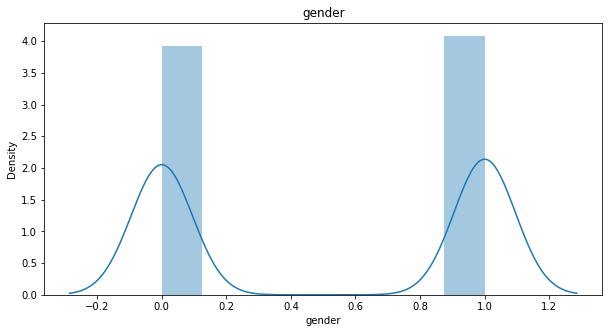

C:\Users\goncharova_aa\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


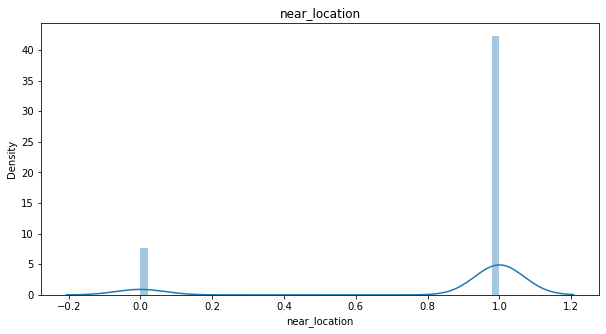

C:\Users\goncharova_aa\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


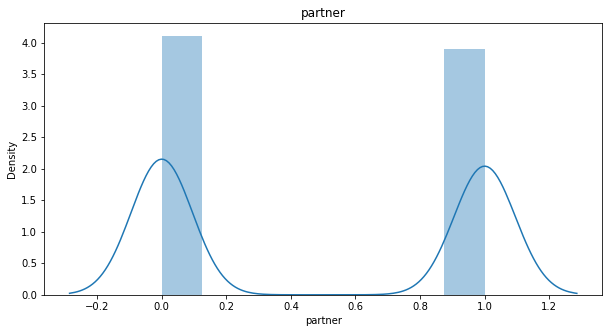

C:\Users\goncharova_aa\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


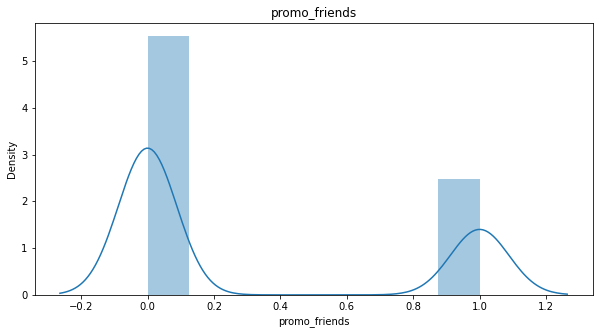

C:\Users\goncharova_aa\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


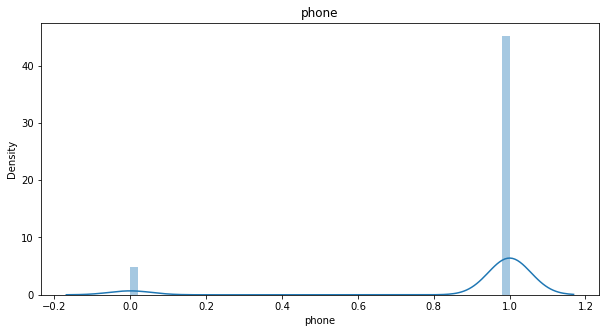

C:\Users\goncharova_aa\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


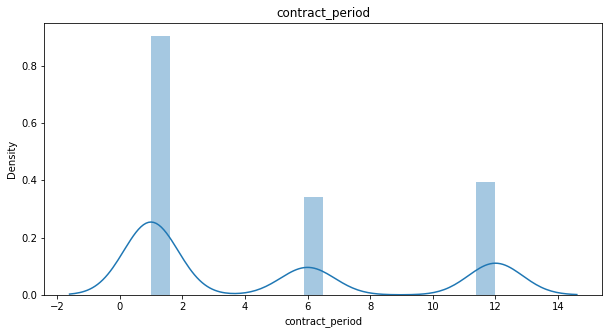

C:\Users\goncharova_aa\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


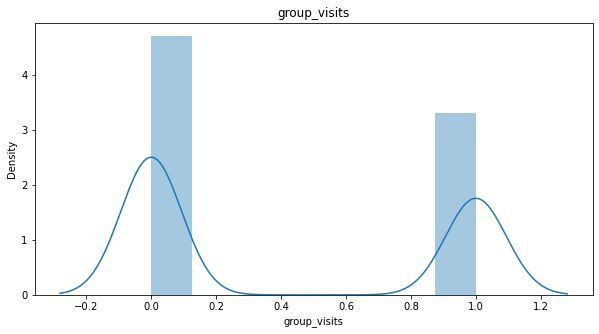

C:\Users\goncharova_aa\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


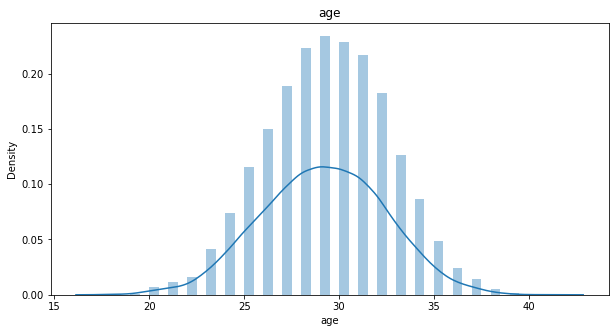

C:\Users\goncharova_aa\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


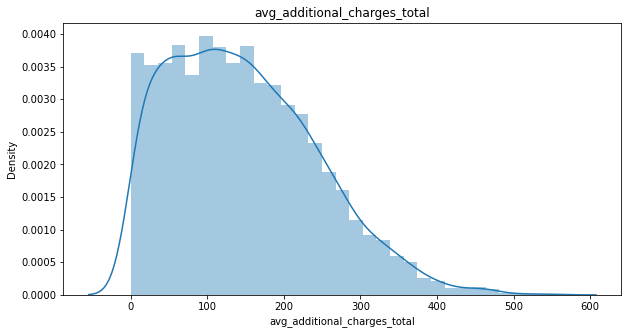

C:\Users\goncharova_aa\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


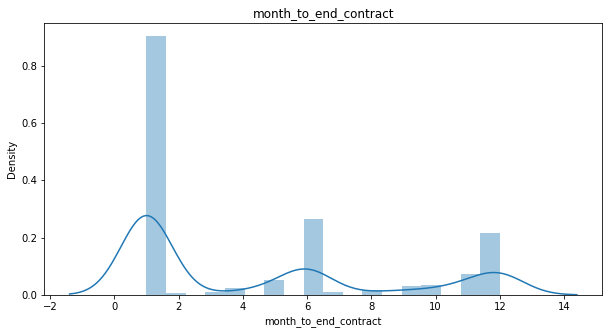

C:\Users\goncharova_aa\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


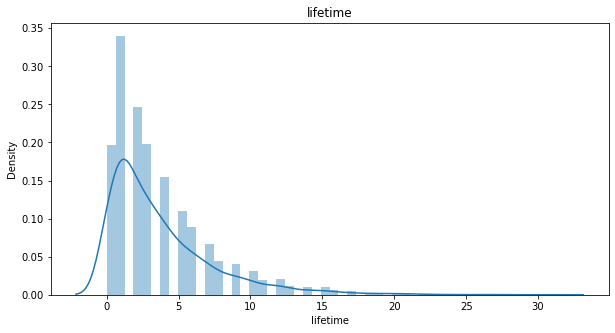

C:\Users\goncharova_aa\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


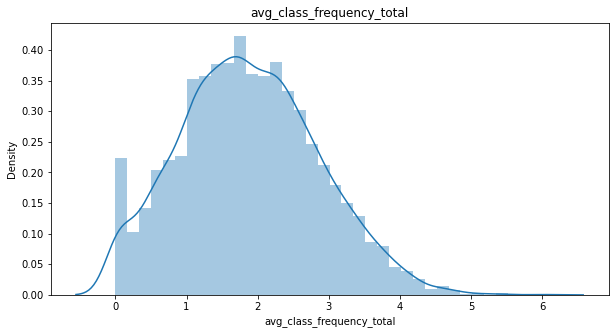

C:\Users\goncharova_aa\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


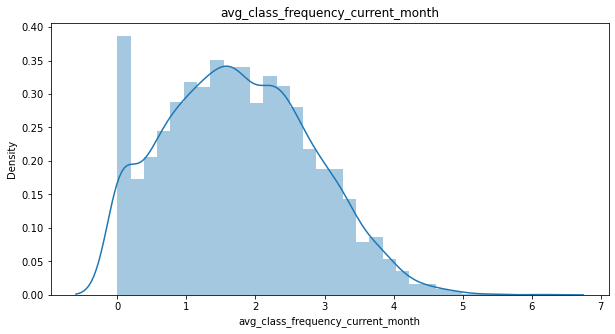

C:\Users\goncharova_aa\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


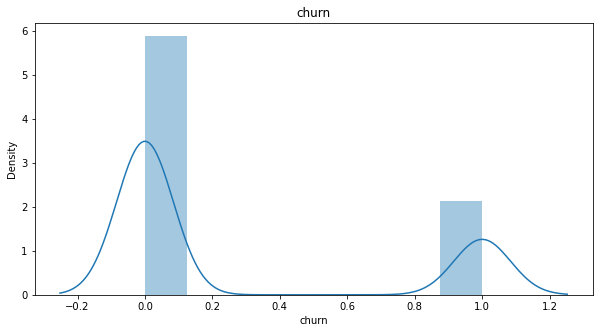

In [ ]:
for columns in data.columns:
    plt.figure(figsize=(10, 5))
    data.groupby('churn')[columns]
    sns.distplot(data[columns], )
    plt.title(columns)
    plt.show()

In [ ]:
count_columns= ['age', 'avg_additional_charges_total', 'avg_class_frequency_current_month', 'avg_class_frequency_total']

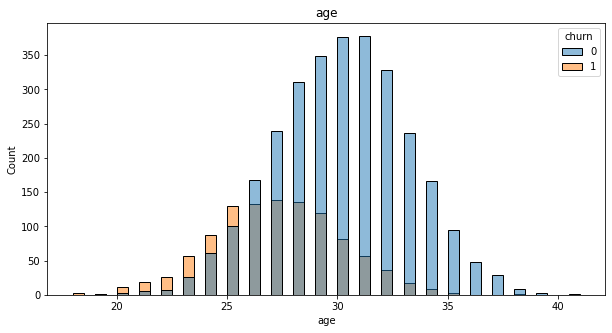

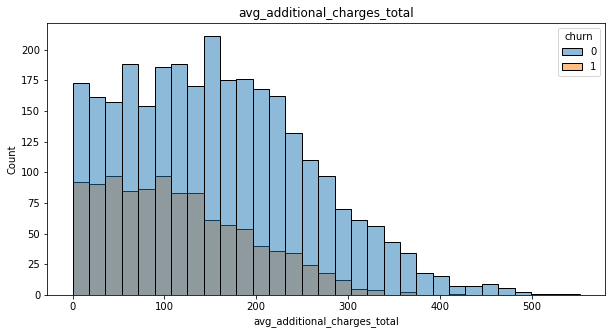

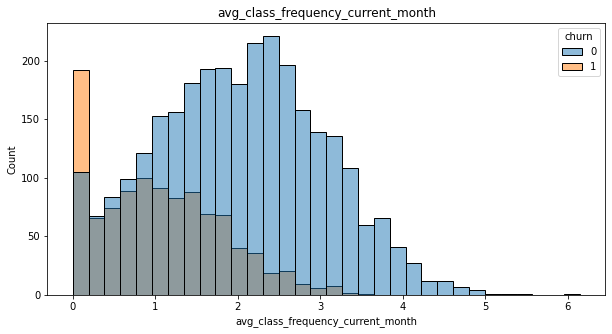

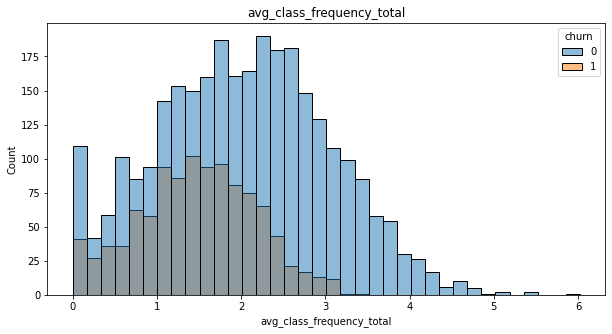

In [ ]:
for columns in count_columns:
    plt.figure(figsize=(10, 5))
    data.groupby('churn')[columns]
    sns.histplot(data = data,  x=data[columns], hue="churn")
    plt.title(columns)
    plt.show()

In [ ]:
disc_columns= ['month_to_end_contract', 'promo_friends', 'near_location', 'contract_period', 'lifetime', 'group_visits', 'contract_period']

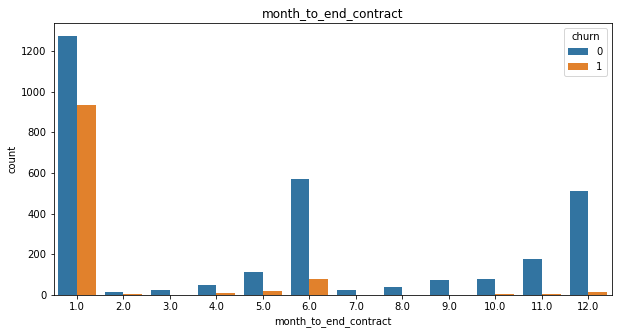

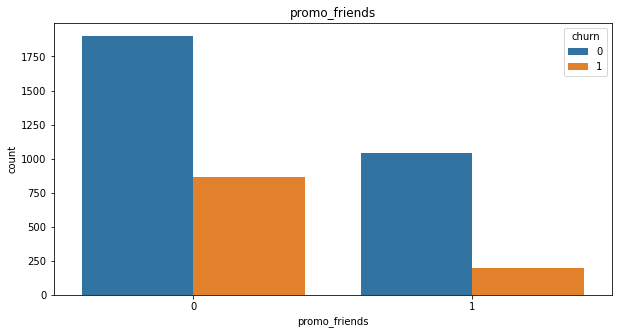

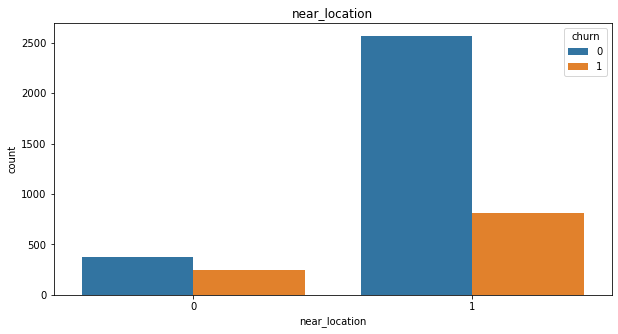

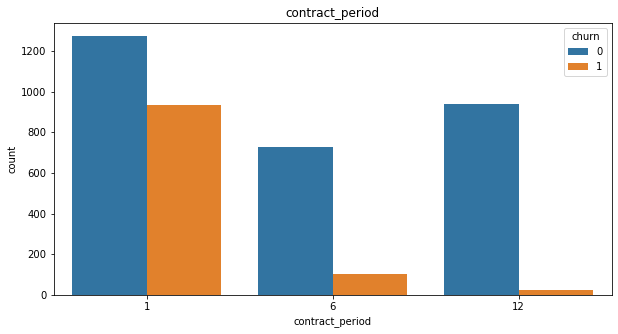

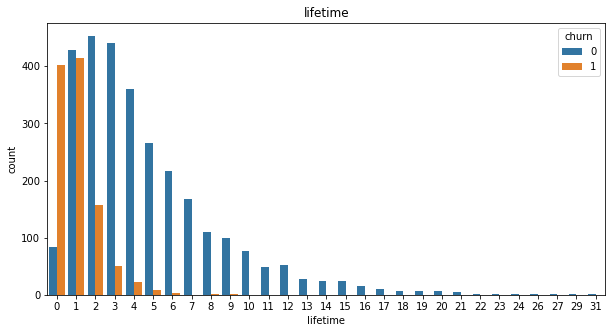

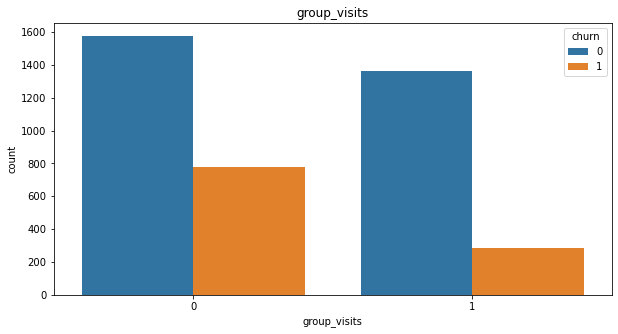

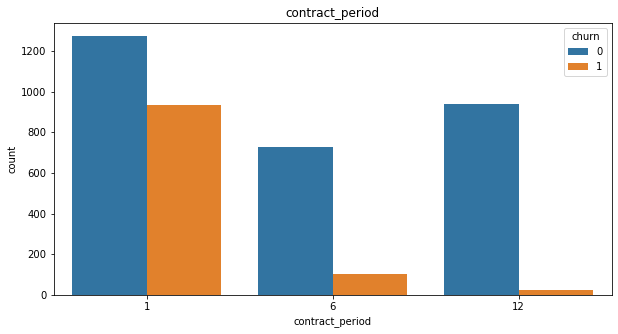

In [ ]:
for columns in disc_columns:
    plt.figure(figsize=(10, 5))
    data.groupby('churn')[columns]
    sns.countplot(data = data,  x=data[columns], hue="churn")
    plt.title(columns)
    plt.show()

По этим графикам мы можем сделать выводы:  
1. В среднем люди посещают клуб около 2 раз в неделю.  
2. В основном клиенты, которые ходят 2-5 месяцев. Если клуб только открылся, то это нормально, а если давно работает, то это плохой показатель. Мы не способны удерживать клиентов на долгое время.
3. Наша целевая аудиторя по возрасту 25-33 лет.  
4. У нас 3 вида абонементов 1-6-12 месяцев. Большинство клиентов предпочитают брать месячные абонементы.

In [ ]:
current_clients = data.pivot_table(index = 'churn', aggfunc = 'mean' )
current_clients.head()

,age,avg_additional_charges_total,avg_class_frequency_current_month,avg_class_frequency_total,contract_period,gender,group_visits,lifetime,month_to_end_contract,near_location,partner,phone,promo_friends
churn,,,,,,,,,,,,,
0,29.976523,158.445715,2.027882,2.024876,5.747193,0.510037,0.464103,4.711807,5.283089,0.873086,0.534195,0.903709,0.353522
1,26.989632,115.082899,1.044546,1.474995,1.728558,0.510839,0.268615,0.990575,1.662582,0.768143,0.355325,0.902922,0.183789


1. Средний возраст ушедших людей меньше, чем оставшихся. Возможно плохо работаем с молодой аудиторией.
2. Cуммарная выручка от дополнительных услуг фитнес-центра у ушедших клиентов ниже, чем у оставшихся.  
3. Сильно различается средняя величина посещений за предыдущий месяц. У ушедших клиентов она 1 раз в неделю, а у оставшихся 2 раза в неделю. Тут возможны несколько вариантов. Или эти клиенты были не довольны качеством обслуживания и не хотели ходить в клуб или им просто было не удобно/не хотелось заниматься спортом вообще. Есть большая разница ушли ли наши клиенты в другой клуб или перестали заниматься спортом совсем.  
4. Длительность текущего действующего абонемента сильно ниже у ушедших клиентов. Возможно плохо работаем с новичками, а возможно стоит вообще отказаться от месячных абонементов, так как вероятность оттока у таких клиентов выше.  
5. Также ушедшие клиенты намного реже посещают груповые занятия. Возможно групповые занятия позволяют удерживать клиентов, потому что там они находят друзей, общаются с тренером (а ему бывает сложно объяснить, почему ты не был на предыдущем занятии), соревновательный дух.
6. Мы видим, что средняя длительность посещения клуба у ушедших клиентов месяц. Это значит плохо удерживаем новых клиентов. Для того, чтобы понять причины ухода, нужно более детальное исследование. Предлагаю обзвонить ушедших клиентов и спросить причину ухода. Возможно, у плохое качество обслуживания или рядом конкурент, которых предлагает более выгодные условия.
7. Разница близости фитнес клуба к месту проживания или работы практически не отличается у обеих групп.   
8. Доля людей, с корпоративными скидками у оставшихся клиентов больше, чем у ушедших. Корпоративные скидки помогают удерживать клиентов. Причин для этого несколько. Некоторым сотрудникам компания полностью компенсирует занятия. Такие клиенты не уйдут к конкурентам. Также, если Ваш коллега ходит в этот же фитнес-клуб, то Вам будет интереснее ходить с ним вместе.  
9. Наличие друга повышает вероятность остаться в этом фитнес-клубе.   



In [ ]:
current_clients= current_clients.reset_index()
current_clients.head()

,churn,age,avg_additional_charges_total,avg_class_frequency_current_month,avg_class_frequency_total,contract_period,gender,group_visits,lifetime,month_to_end_contract,near_location,partner,phone,promo_friends
0,0,29.976523,158.445715,2.027882,2.024876,5.747193,0.510037,0.464103,4.711807,5.283089,0.873086,0.534195,0.903709,0.353522
1,1,26.989632,115.082899,1.044546,1.474995,1.728558,0.510839,0.268615,0.990575,1.662582,0.768143,0.355325,0.902922,0.183789


In [ ]:
x = data[data['churn'] == 1]
y = data[data['churn'] == 0]
# 1 - ушли,  0 - остались

#### Проанализируем возраст клиентов

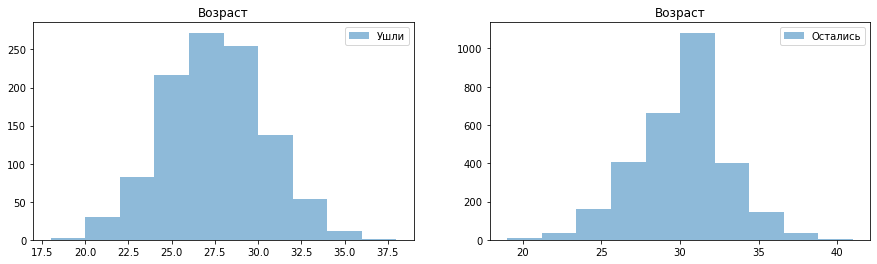

In [ ]:
fig, ax = plt.subplots(figsize=(15,4), nrows=1, ncols=2);
ax[0].hist(x['age'], alpha = 0.5, label='Ушли')
ax[1].hist(y['age'], alpha = 0.5, label='Остались')
ax[0].legend()
ax[1].legend()
ax[0].set_title('Возраст')
ax[1].set_title('Возраст')
plt.show()


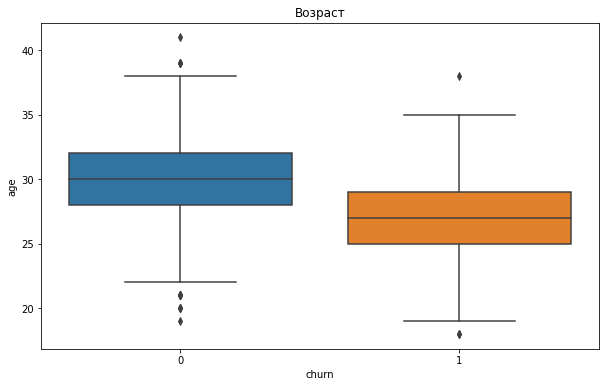

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
ax = sns.boxplot(x="churn", y="age", data=data)
ax.set_title('Возраст')
plt.show()

В основном уходят клиенты 26 лет.

#### Количество посещений в неделю в этом месяце

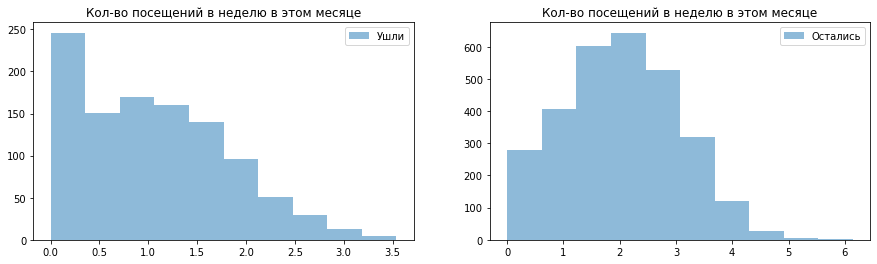

In [ ]:
fig, ax = plt.subplots(figsize=(15,4), nrows=1, ncols=2);
ax[0].hist(x['avg_class_frequency_current_month'], alpha = 0.5, label='Ушли')
ax[1].hist(y['avg_class_frequency_current_month'], alpha = 0.5, label='Остались')
ax[0].legend()
ax[1].legend()
ax[0].set_title('Кол-во посещений в неделю в этом месяце')
ax[1].set_title('Кол-во посещений в неделю в этом месяце')
plt.show()


Ущедшие клиенты посещают клуб намного реже, чем оставшиеся.

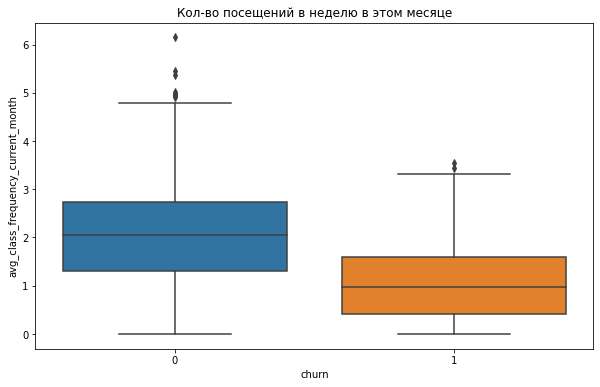

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
ax = sns.boxplot(x="churn", y="avg_class_frequency_current_month", data=data)
ax.set_title('Кол-во посещений в неделю в этом месяце')
plt.show()

#### Затраты на дополнительные услуги

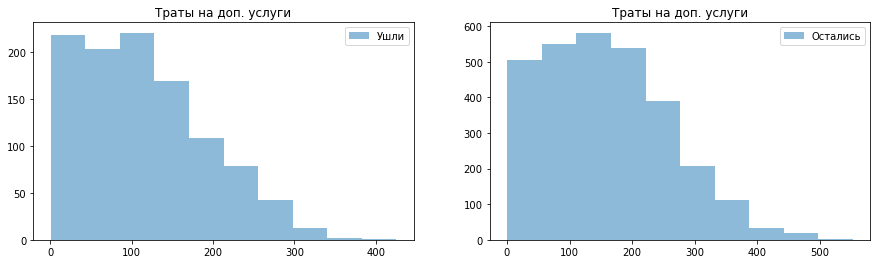

In [ ]:
fig, ax = plt.subplots(figsize=(15,4), nrows=1, ncols=2);
ax[0].hist(x['avg_additional_charges_total'], alpha = 0.5, label='Ушли')
ax[1].hist(y['avg_additional_charges_total'], alpha = 0.5, label='Остались')
ax[0].legend()
ax[1].legend()
ax[0].set_title('Траты на доп. услуги')
ax[1].set_title('Траты на доп. услуги')
plt.show()


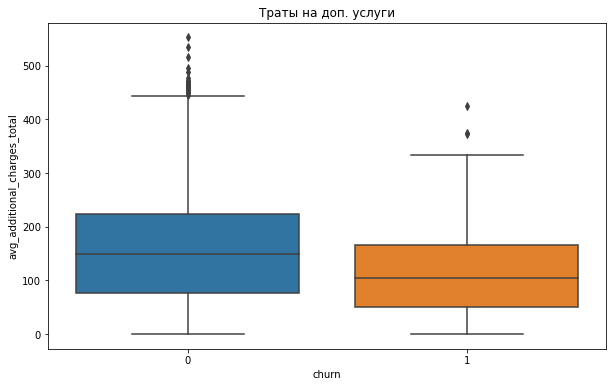

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
ax = sns.boxplot(x="churn", y="avg_additional_charges_total", data=data)
ax.set_title('Траты на доп. услуги')
plt.show()

Оставшиеся клиенты тратят больше на дополнительные услуги, чем ушедшие.

#### Длительность абонемента

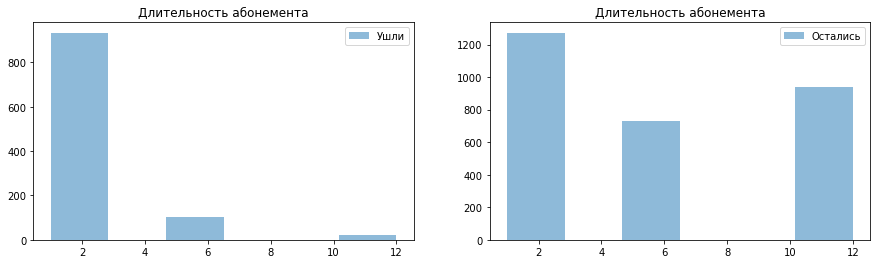

In [ ]:
fig, ax = plt.subplots(figsize=(15,4), nrows=1, ncols=2);
ax[0].hist(x['contract_period'], alpha = 0.5, label='Ушли', bins = 6)
ax[1].hist(y['contract_period'], alpha = 0.5, label='Остались',  bins = 6)
ax[0].legend()
ax[1].legend()
ax[0].set_title('Длительность абонемента')
ax[1].set_title('Длительность абонемента')
plt.show()

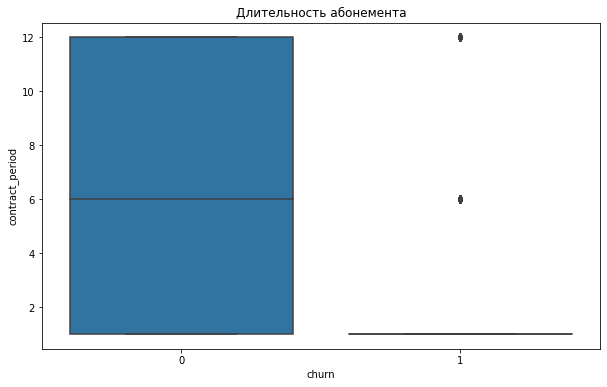

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
ax = sns.boxplot(x="churn", y="contract_period", data=data)
ax.set_title('Длительность абонемента')
plt.show()

Мы видим, что в обоих случаях, клиенты предпочитают месячный абонемент. Однако у тех клиентов, которые остались намного больше полугодовых и годовых абонементов. У клиентов, которые ушли годовых и полугодовых абонементов почти нет.  
Подведем итог, что чем больше длительность абонемента, тем вероятнее останется клиент.

#### Посещения групповых занятий

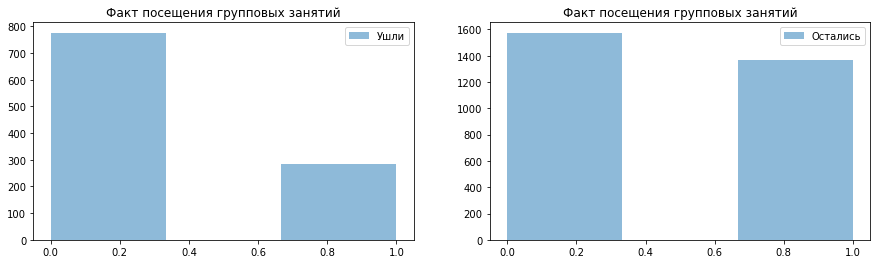

In [ ]:
fig, ax = plt.subplots(figsize=(15,4), nrows=1, ncols=2);
ax[0].hist(x['group_visits'], alpha = 0.5, label='Ушли', bins = 3)
ax[1].hist(y['group_visits'], alpha = 0.5, label='Остались',  bins = 3)
ax[0].legend()
ax[1].legend()
ax[0].set_title('Факт посещения групповых занятий')
ax[1].set_title('Факт посещения групповых занятий')
plt.show()

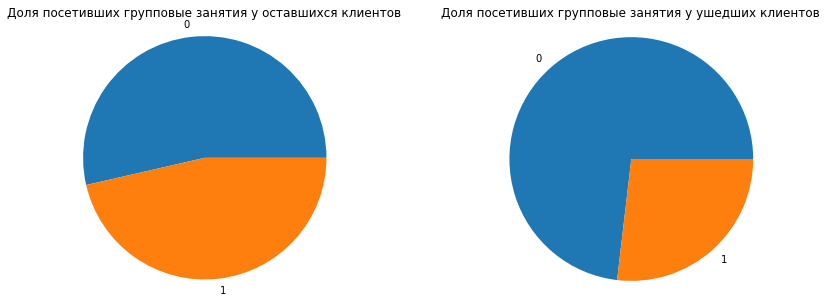

In [ ]:
d_grouped_chain = y.groupby(['group_visits'])['churn'].count()
d_grouped_chain = d_grouped_chain.reset_index().sort_values(by = 'churn', ascending=False)
vals_chain = d_grouped_chain['churn'].values
labels_chain = d_grouped_chain['group_visits']
fig = plt.figure(figsize=(14,5))
ax = fig.subplots(1, 2)
ax[0].pie(vals_chain, labels=labels_chain)
ax[0].axis("equal")
ax[0].set_title('Доля посетивших групповые занятия у оставшихся клиентов');

d_grouped_alone = x.groupby(['group_visits'])['churn'].count()
d_grouped_alone = d_grouped_alone.reset_index().sort_values(by = 'churn', ascending=False)
labels_alone = d_grouped_alone['group_visits']
values_alone = d_grouped_alone['churn'].values
#ax = plt.subplots()
ax[1].pie(values_alone, labels=labels_alone)
ax[1].axis("equal")
ax[1].set_title('Доля посетивших групповые занятия у ушедших клиентов');

Мы видим, что доля посетивших групповые занятия у оставшихся клиентов намного больше, чем у ушедших. Это означает, что групповые занятия помогают удерживать клиентов.

#### Cрок до окончания текущего действующего абонемента

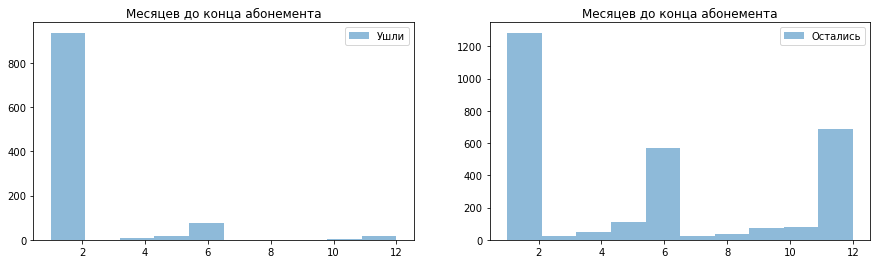

In [ ]:
fig, ax = plt.subplots(figsize=(15,4), nrows=1, ncols=2);
ax[0].hist(x['month_to_end_contract'], alpha = 0.5, label='Ушли')
ax[1].hist(y['month_to_end_contract'], alpha = 0.5, label='Остались')
ax[0].legend()
ax[1].legend()
ax[0].set_title('Месяцев до конца абонемента')
ax[1].set_title('Месяцев до конца абонемента')
plt.show()


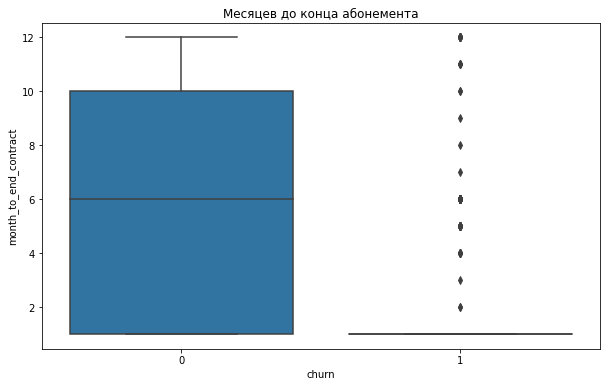

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
ax = sns.boxplot(x="churn", y="month_to_end_contract", data=data)
ax.set_title('Месяцев до конца абонемента')
plt.show()

Мы видим, что очень мало клиентов уходит с абонементами в 6 и 12 месяцев до конца действия абонемента. Чаще всего они уходят в последний месяц действия абонемента, что логично. Дождаться окончания абонемента и уйти.

#### Прошло месяцев с момента первого посещения

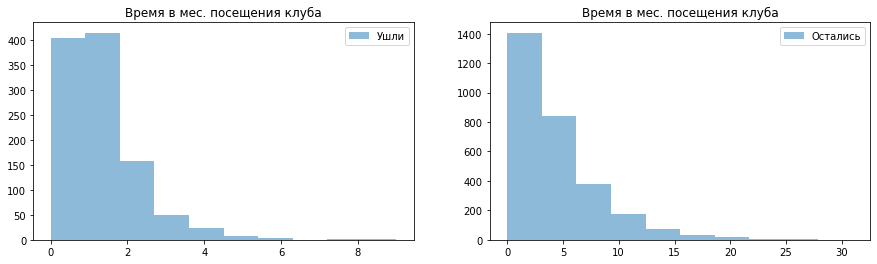

In [ ]:
fig, ax = plt.subplots(figsize=(15,4), nrows=1, ncols=2);
ax[0].hist(x['lifetime'], alpha = 0.5, label='Ушли')
ax[1].hist(y['lifetime'], alpha = 0.5, label='Остались')
ax[0].legend()
ax[1].legend()
ax[0].set_title('Время в мес. посещения клуба')
ax[1].set_title('Время в мес. посещения клуба')
plt.show()

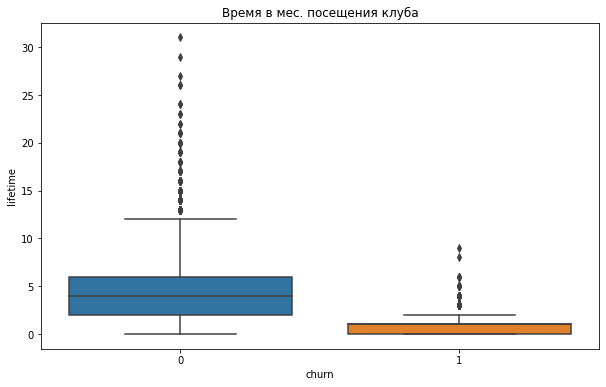

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
ax = sns.boxplot(x="churn", y="lifetime", data=data)
ax.set_title('Время в мес. посещения клуба')
plt.show()

Мы видим, что средняя длительность посещения клуба у ушедших клиентов месяц. Возможно, мы плохо удерживаем новых клиентов. Это очень сильно отличается от оставшихся клиентов, которые посещают клуб в среднем 4 месяца.

#### Promo_friends — факт первоначальной записи в рамках акции «приведи друга»

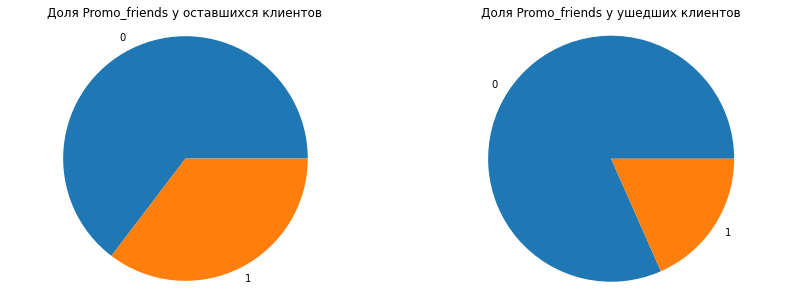

In [ ]:
d_grouped_chain = y.groupby(['promo_friends'])['churn'].count()
d_grouped_chain = d_grouped_chain.reset_index().sort_values(by = 'churn', ascending=False)
vals_chain = d_grouped_chain['churn'].values
labels_chain = d_grouped_chain['promo_friends']
fig = plt.figure(figsize=(14,5))
ax = fig.subplots(1, 2)
ax[0].pie(vals_chain, labels=labels_chain)
ax[0].axis("equal")
ax[0].set_title('Доля Promo_friends у оставшихся клиентов');

d_grouped_alone = x.groupby(['promo_friends'])['churn'].count()
d_grouped_alone = d_grouped_alone.reset_index().sort_values(by = 'churn', ascending=False)
labels_alone = d_grouped_alone['promo_friends']
values_alone = d_grouped_alone['churn'].values
#ax = plt.subplots()
ax[1].pie(values_alone, labels=labels_alone)
ax[1].axis("equal")
ax[1].set_title('Доля Promo_friends у ушедших клиентов');

Мы видим, что наличие друга, который ходит с тобой в тот же фитнес клуб повышает лояльность к клубу.

#### Сотрудник компании-партнёра клуба

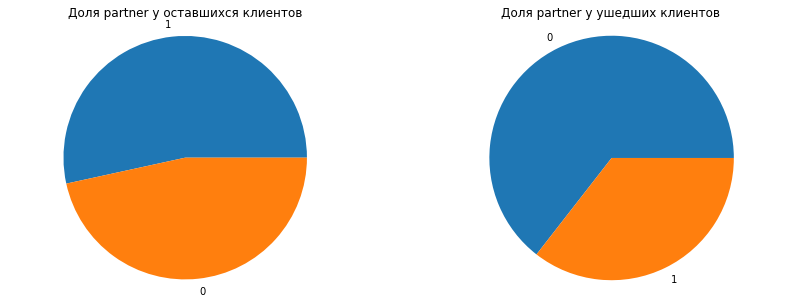

In [ ]:
d_grouped_chain = y.groupby(['partner'])['churn'].count()
d_grouped_chain = d_grouped_chain.reset_index().sort_values(by = 'churn', ascending=False)
vals_chain = d_grouped_chain['churn'].values
labels_chain = d_grouped_chain['partner']
fig = plt.figure(figsize=(14,5))
ax = fig.subplots(1, 2)
ax[0].pie(vals_chain, labels=labels_chain)
ax[0].axis("equal")
ax[0].set_title('Доля partner у оставшихся клиентов');

d_grouped_alone = x.groupby(['partner'])['churn'].count()
d_grouped_alone = d_grouped_alone.reset_index().sort_values(by = 'churn', ascending=False)
labels_alone = d_grouped_alone['partner']
values_alone = d_grouped_alone['churn'].values
#ax = plt.subplots()
ax[1].pie(values_alone, labels=labels_alone)
ax[1].axis("equal")
ax[1].set_title('Доля partner у ушедших клиентов');

Мы видим, что скидки корпоративным клиентам повышеает лояльность к клубу, возможно из-за того, что в клуб ходит твой коллега либо из-за более низкой цены.

#### Матрица корреляции

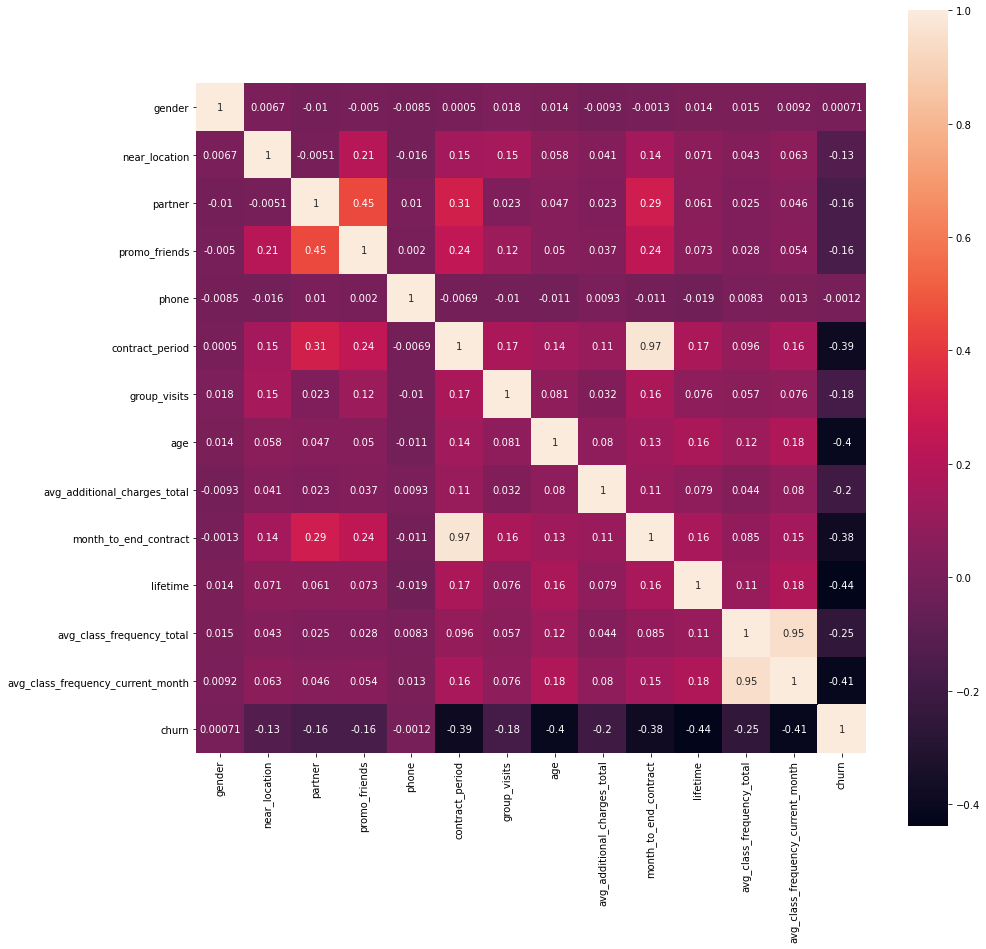

In [ ]:
corr_m =data.corr() # напишите ваш код здесь
plt.figure(figsize = (15,15))
sns.heatmap(corr_m, square = True,annot = True )
plt.show()

С помощью матрицы корреляции мы видим, что на целевую переменную "churn" влияют кол-во посещений в неделю. Чем чаще человек к нам ходит, тем меньше вероятности, что он сменит клуб. Также большая корреляция с длительностью текущего действующего абонемента и временем с момента первого обращения в фитнес-центр. Чем длительнее абонемент, тем лучше удержание клиента. И чем дольше он к нам ходит, тем менее вероятно, что клиент от нас уйдет.

Выводы по матрице корреляции:

"month_to_end_contract" и "contract_period", и у "avg_class_frequency_current_montn" и "avg_class_frequency_total" слишком высокая корреляция. Признаки мультиколлинеарны. Это плохо, потому что:
* Определить значимые переменные будет сложно;
* Может произойти переобучение, и точность модели изменится в зависимости от набора данных.

Решение - удалить некоторые столбцы ("month_to_end_contract", "avg_class_frequency_total") .

In [ ]:
data = data.drop(columns = ['month_to_end_contract', 'avg_class_frequency_total'])

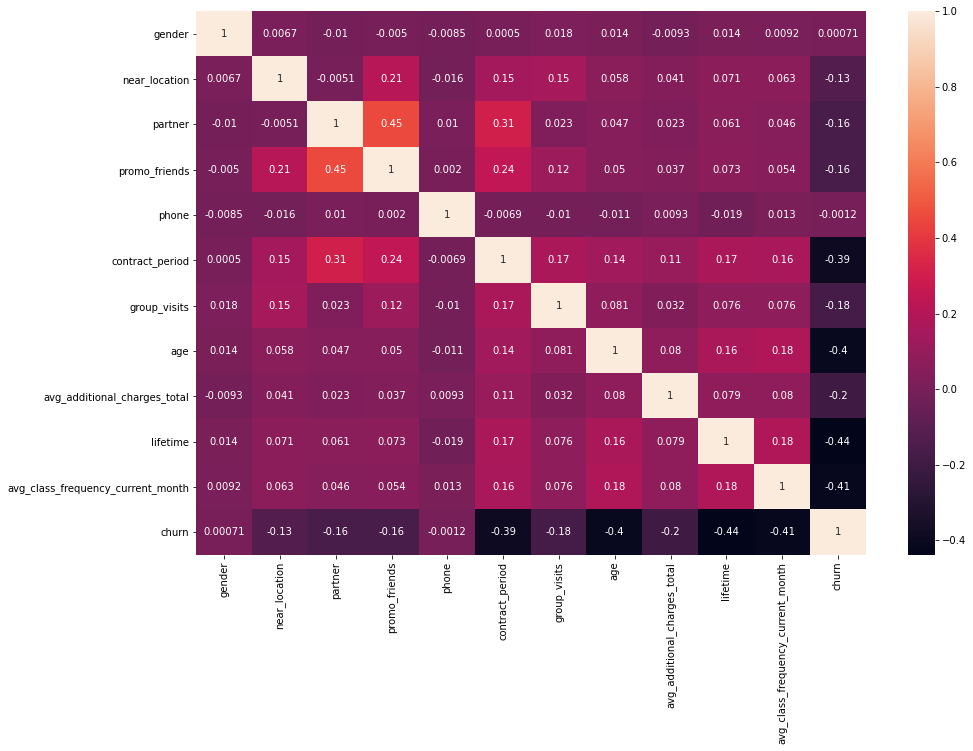

In [ ]:
new_corr = data.corr()
plt.figure(figsize = (15,10))
sns.heatmap(new_corr,
         annot = True)
plt.show()

# Построение модели прогнозирования оттока клиентов

*acc* - доля правильных ответов.  
*recall* - метрика нацелена на минимизацию противоположных рисков —  показывает, сколько реальных объектов "1" класса вы смогли обнаружить с помощью модели.  
*precision* говорит, какая доля прогнозов относительно "1" класса верна. То есть смотрим долю правильных ответов только среди целевого класса.
*F1* -мера сводная метрика, учитывающая баланс между метриками.  
*AUC-ROC*  площадь под кривой ошибок —  (от англ. Area Under Curve, «площадь под кривой», Receiver Operating Characteristic, «рабочая характеристика приёмника»).

Разделим наши данные на признаки (матрица X) и целевую переменную (y). Целевая переменная "churn" факт оттока клиента.

In [ ]:
X = data.drop(columns=['churn'])
y = data['churn']

Разделяем модель на обучающую и валидационную выборку в пропорции 80-20

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0 )

### Предскажим отток методом случайного леса.

In [ ]:
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)
rf_probabilities = rf_model.predict_proba(X_test)[:,1]
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, rf_predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, rf_predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, rf_predictions)))
print('F1: {:.2f}'.format(f1_score(y_test, rf_predictions)))

Accuracy: 0.90
Precision: 0.81
Recall: 0.75
F1: 0.78


In [ ]:
print('ROC_AUC: {:.2f}'.format(roc_auc_score(y_test, rf_probabilities) ))

ROC_AUC: 0.95


### Предскажим отток методом логистической регрессии.

In [ ]:
model = LogisticRegression(solver='liblinear')

model.fit(X_train, y_train)

# воспользуйтесь уже обученной моделью, чтобы сделать прогнозы

predictions = model.predict(X_test)
probabilities = model.predict_proba(X_test)[:,1]

# бинарный прогноз
predictions = model.predict(X_test)

# выведите все изученные метрики для полученного прогноза
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, predictions)))
print('F1: {:.2f}'.format(f1_score(y_test, predictions)))

Accuracy: 0.90
Precision: 0.79
Recall: 0.79
F1: 0.79


In [ ]:
print('ROC_AUC: {:.2f}'.format(roc_auc_score(y_test, probabilities) ))

ROC_AUC: 0.96


Нельзя сказать, что одна метрика важнее другой, так как мы не знаем расходы на удержание клиента. Если они не большие, то, лучше использовать Recall. Причина в тексте:  
*Precision измеряет надежность модели при классификации Positive семплов, а recall определяет, сколько Positive выборок было корректно предсказано моделью.
Precision учитывает классификацию как Positive, так и Negative семплов. Recall же использует при расчете только представителей класса Positive. Другими словами, precision зависит как от Negative, так и от Positive-выборок, но recall — только от Positive.
Precision принимает во внимание, когда семпл определяется как Positive, но не заботится о верной классификации всех объектов класса Positive. Recall в свою очередь учитывает корректность предсказания всех Positive выборок, но не заботится об ошибочной классификации представителей Negative как Positive.
Когда модель имеет высокий уровень recall метрики, но низкую precision, такая модель правильно определяет большинство Positive семплов, но имеет много ложных срабатываний (классификаций Negative выборок как Positive). Если модель имеет большую precision, но низкий recall, то она делает высокоточные предсказания, определяя класс Positive, но производит всего несколько таких прогнозов.*   
Поэтому для нас True Positive намного важнее, чем True Negative. Однако, если же расходы на удержание большие, то лучше использовать Precision.

Вывод: получили точность предсказания в 91% методом случайного леса и 92% методом логистической регрессии. Для предсказания оттока в дальнейшем использовал метод логистической регрессии, так как он показывает себя лучше.

# Кластера

Обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов.

In [ ]:
sc = StandardScaler()
x_sc = sc.fit_transform(X)
km = KMeans(n_clusters=5, random_state=0) # задаём число кластеров, равное 5, и фиксируем значение random_state для воспроизводимости результата
labels = km.fit_predict(x_sc) # применяем алгоритм к данным и формируем вектор кластеров

Giving up send_request(...) after 11 tries (requests.exceptions.ConnectionError: HTTPSConnectionPool(host='api.segment.io', port=443): Max retries exceeded with url: /v1/batch (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x0000024CC6666550>: Failed to establish a new connection: [Errno 11004] getaddrinfo failed')))
error uploading: HTTPSConnectionPool(host='api.segment.io', port=443): Max retries exceeded with url: /v1/batch (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x0000024CC6666550>: Failed to establish a new connection: [Errno 11004] getaddrinfo failed'))


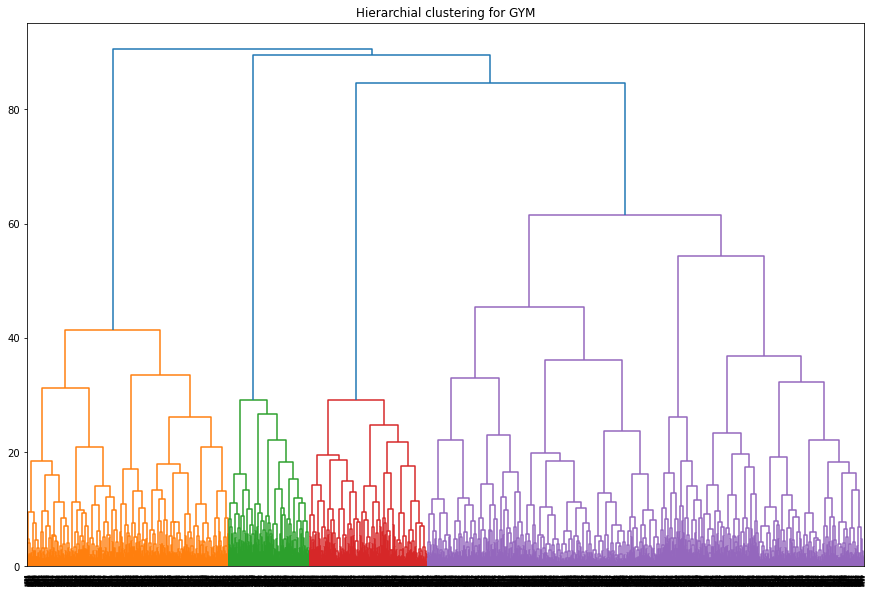

In [ ]:
linked = linkage(x_sc, method = 'ward')
plt.figure(figsize=(15, 10))
dendrogram(linked, orientation='top')
plt.title('Hierarchial clustering for GYM')
plt.show()

C:\Users\goncharova_aa\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


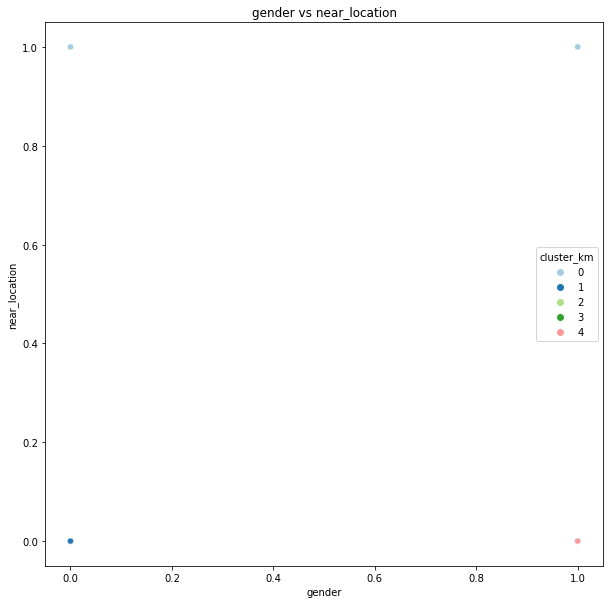

C:\Users\goncharova_aa\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


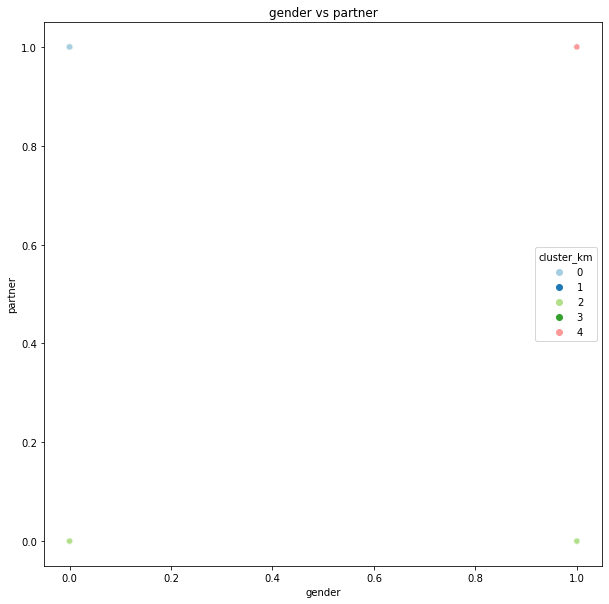

C:\Users\goncharova_aa\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


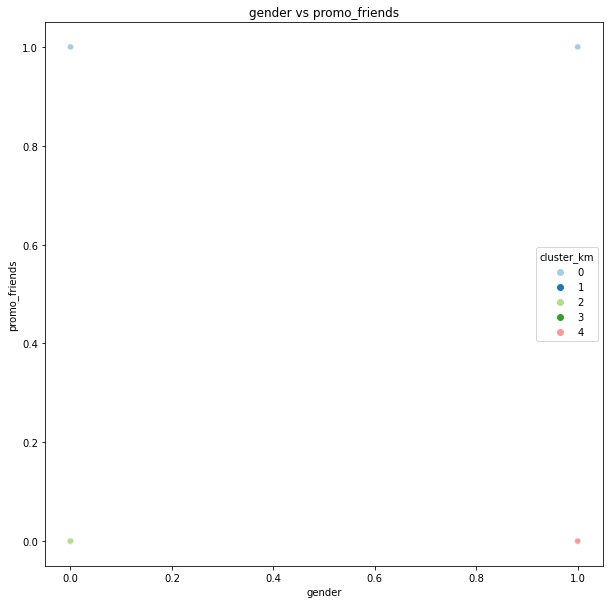

C:\Users\goncharova_aa\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


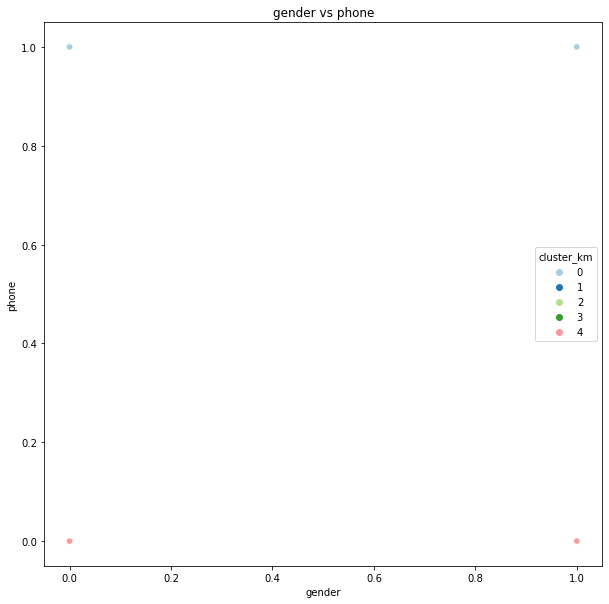

C:\Users\goncharova_aa\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


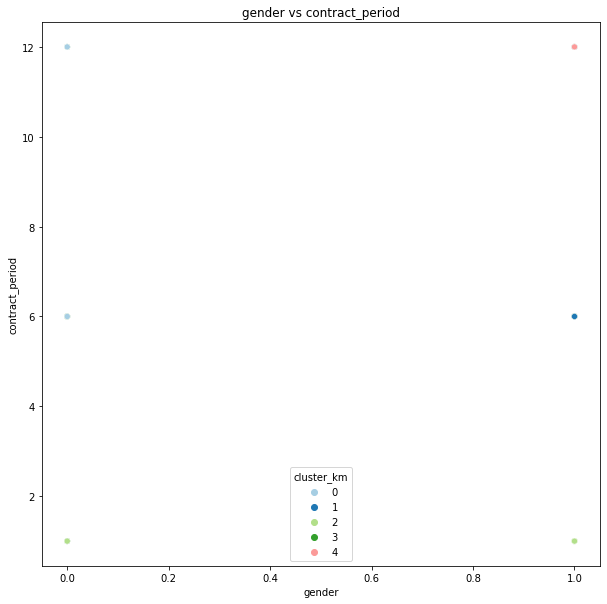

C:\Users\goncharova_aa\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


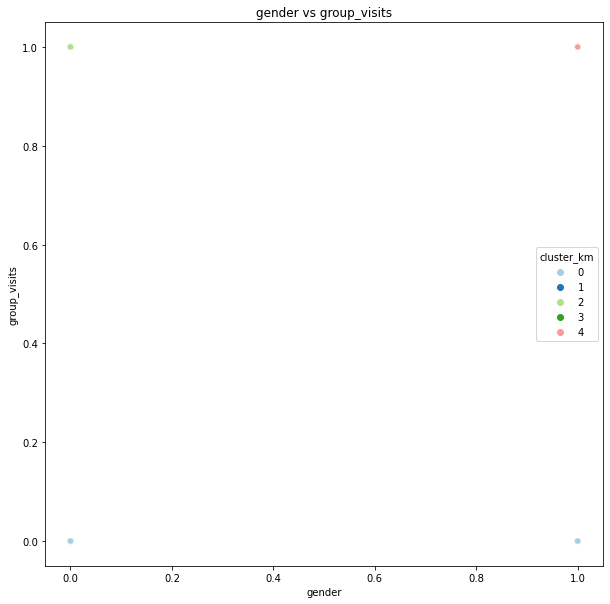

C:\Users\goncharova_aa\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


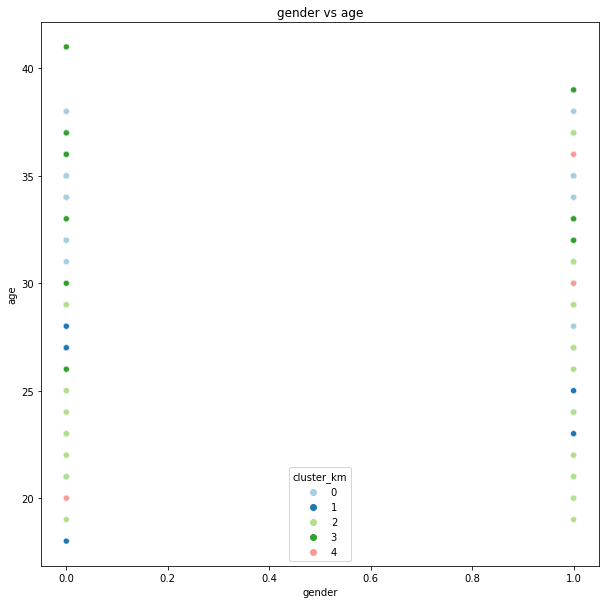

C:\Users\goncharova_aa\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


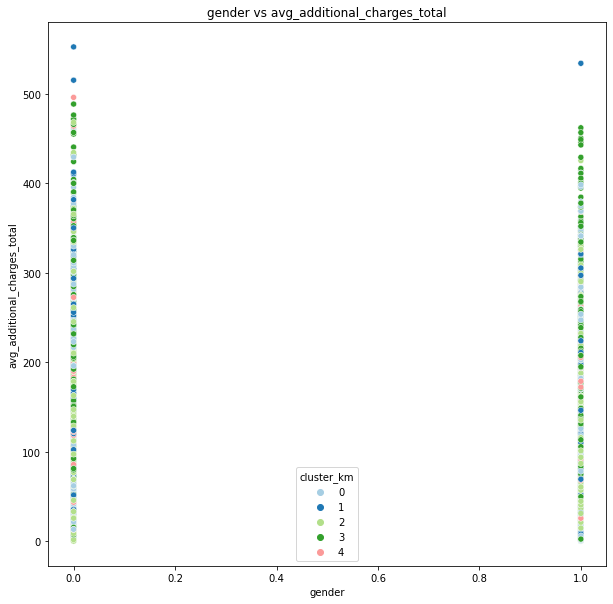

C:\Users\goncharova_aa\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


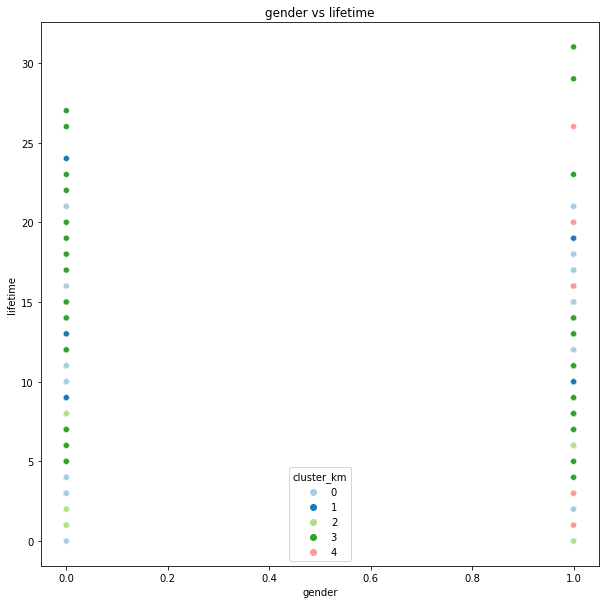

C:\Users\goncharova_aa\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


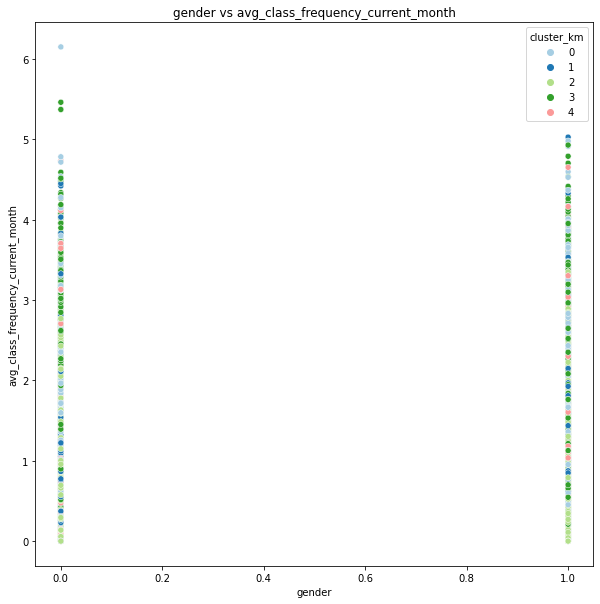

C:\Users\goncharova_aa\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


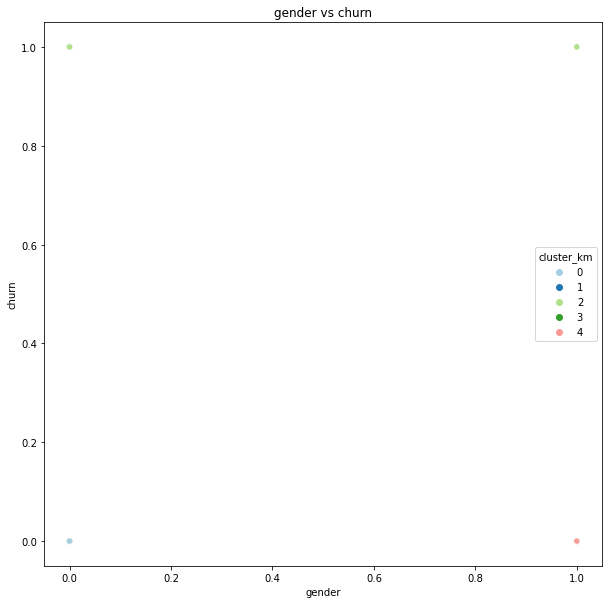

C:\Users\goncharova_aa\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


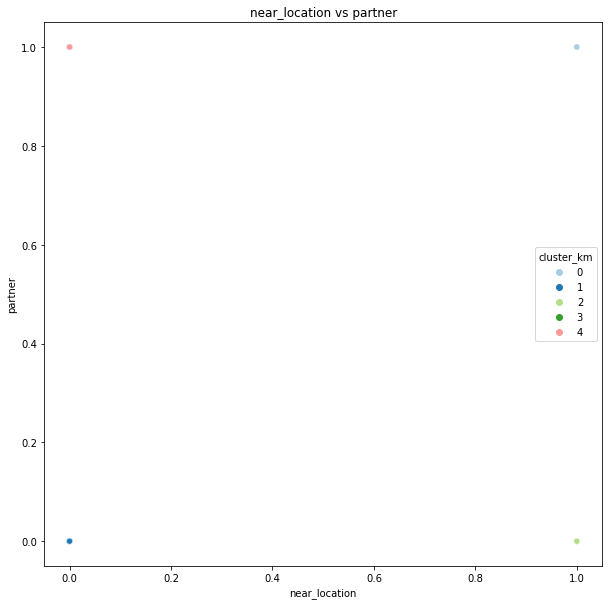

C:\Users\goncharova_aa\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


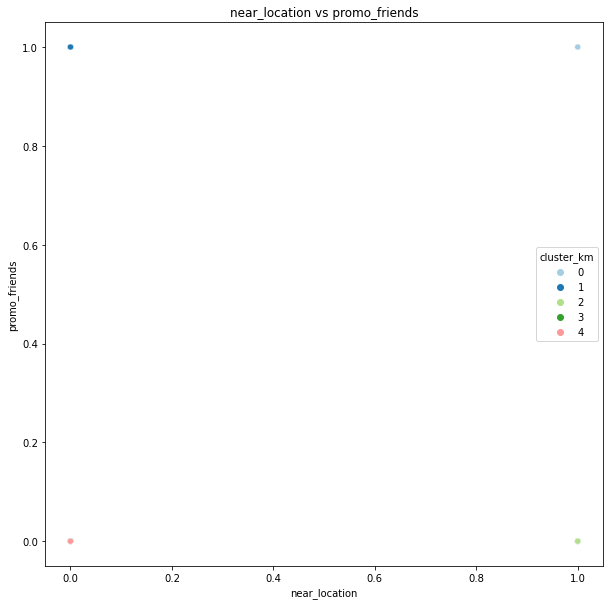

C:\Users\goncharova_aa\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


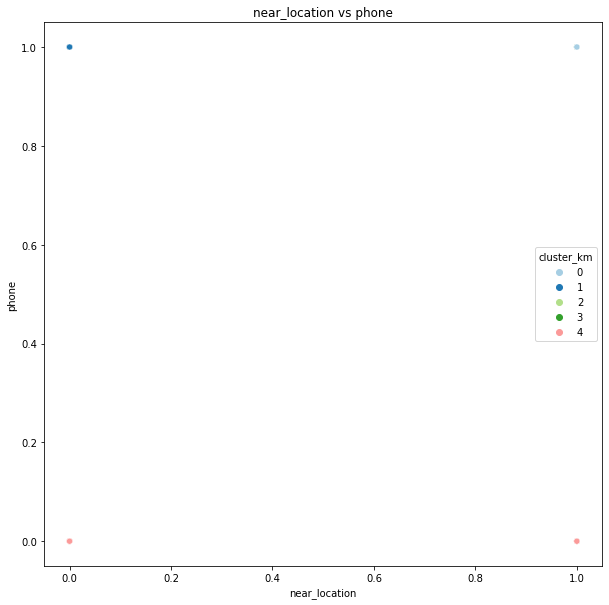

C:\Users\goncharova_aa\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


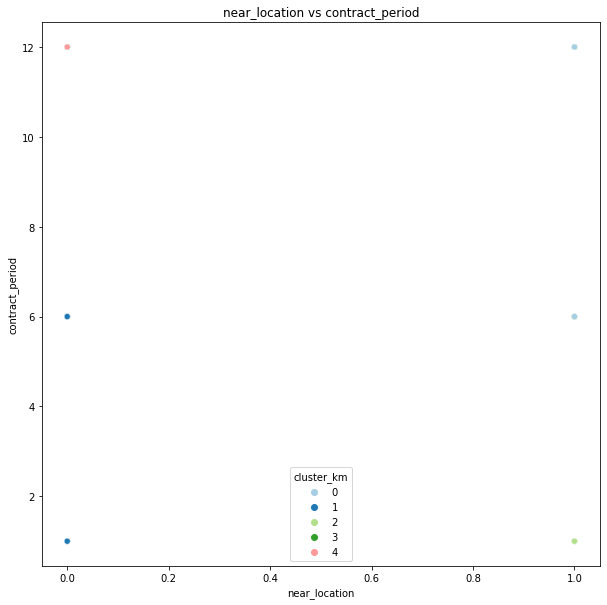

C:\Users\goncharova_aa\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


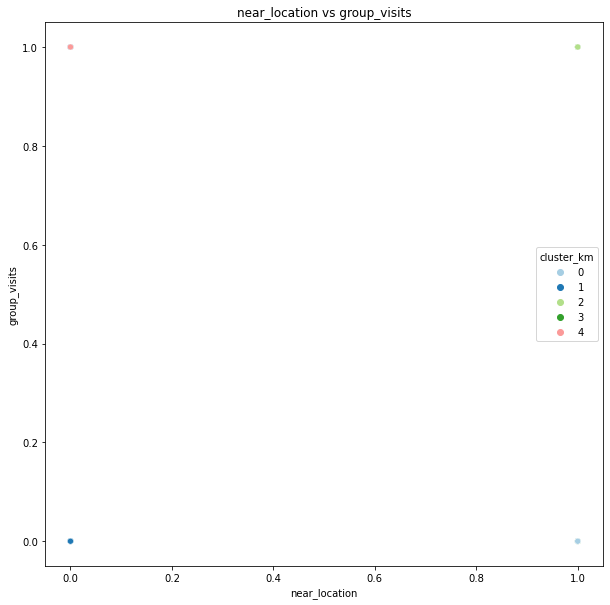

C:\Users\goncharova_aa\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


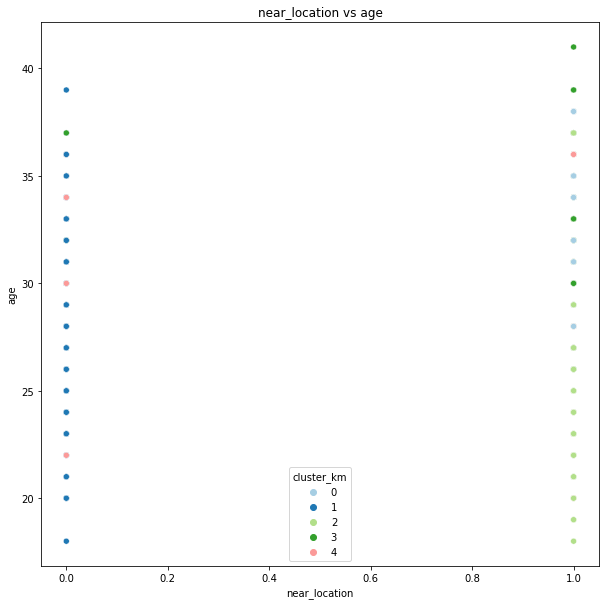

C:\Users\goncharova_aa\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


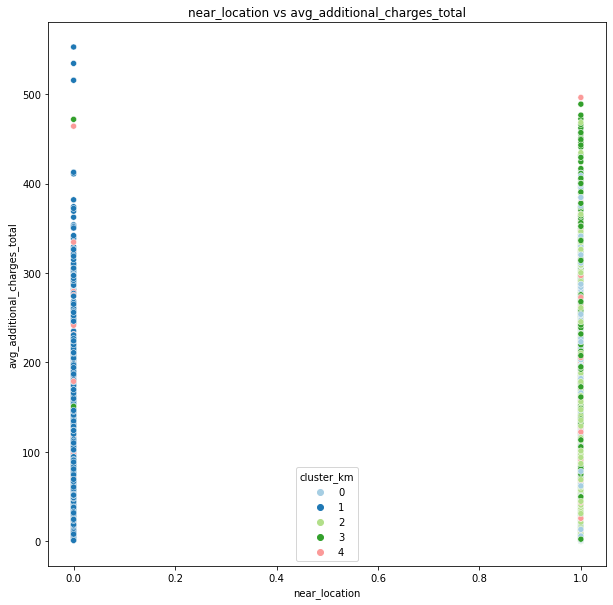

C:\Users\goncharova_aa\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


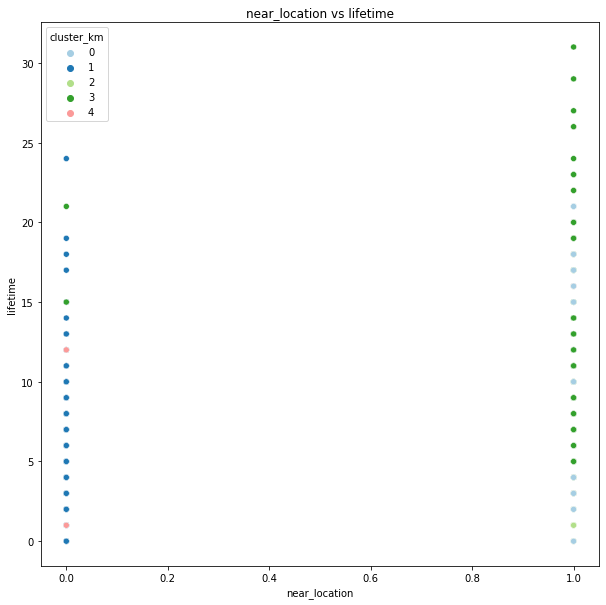

C:\Users\goncharova_aa\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


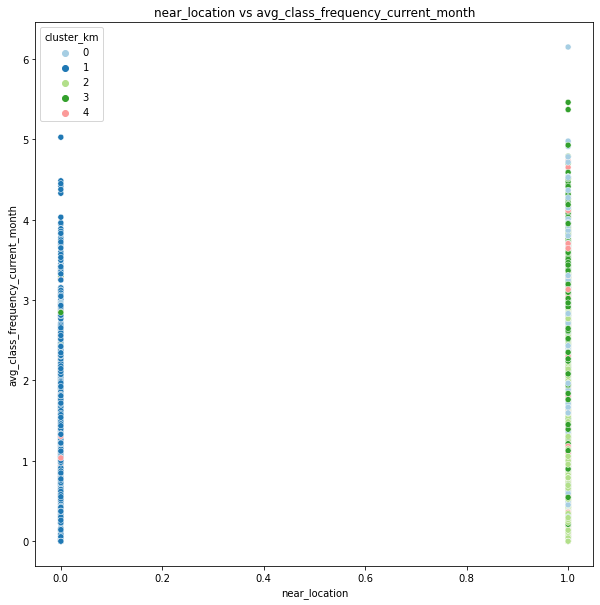

C:\Users\goncharova_aa\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


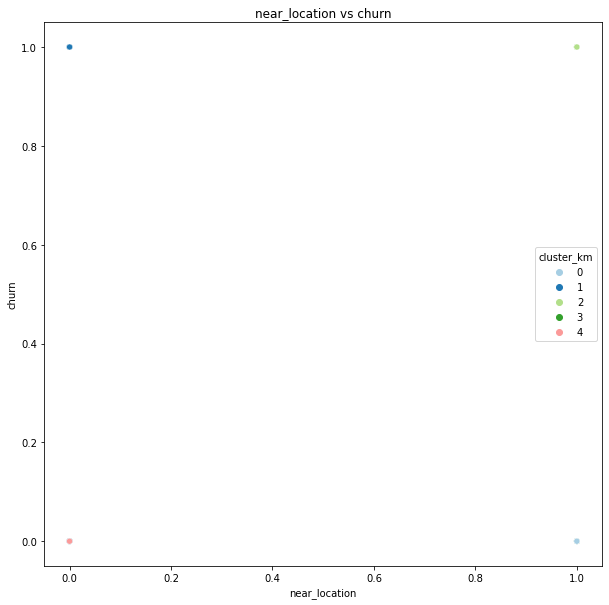

C:\Users\goncharova_aa\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


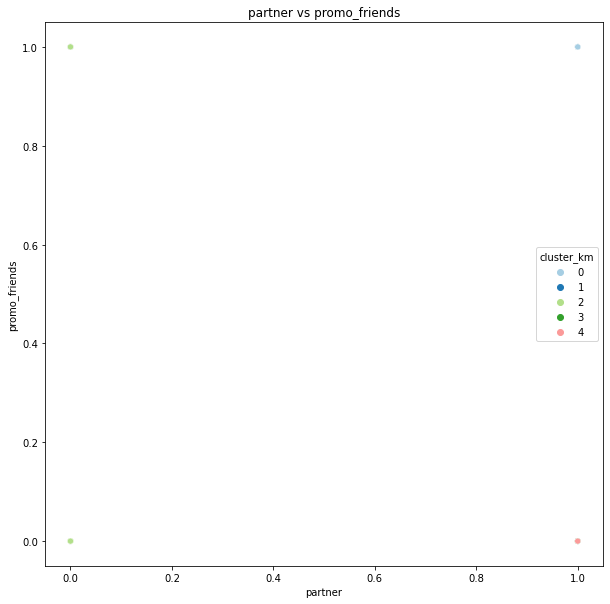

C:\Users\goncharova_aa\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


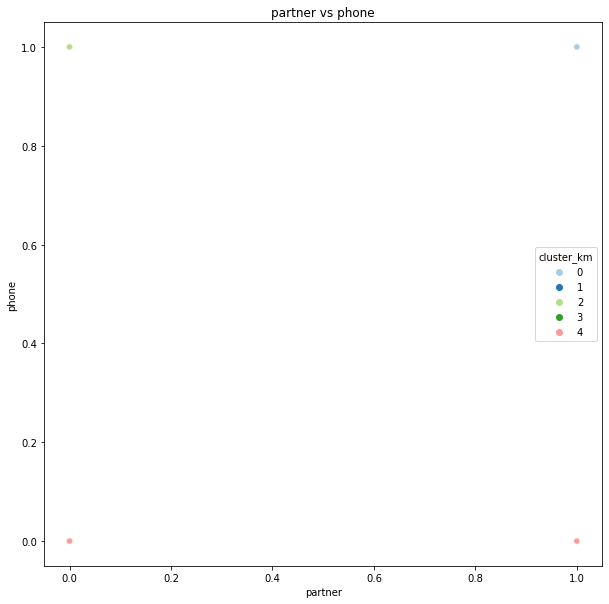

C:\Users\goncharova_aa\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


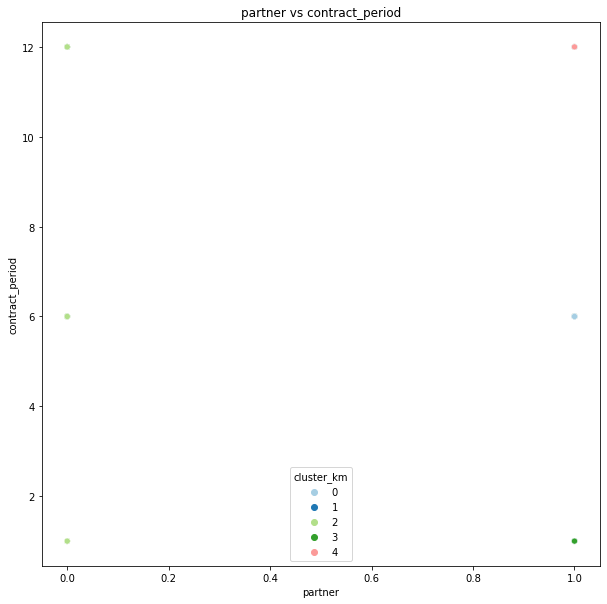

C:\Users\goncharova_aa\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


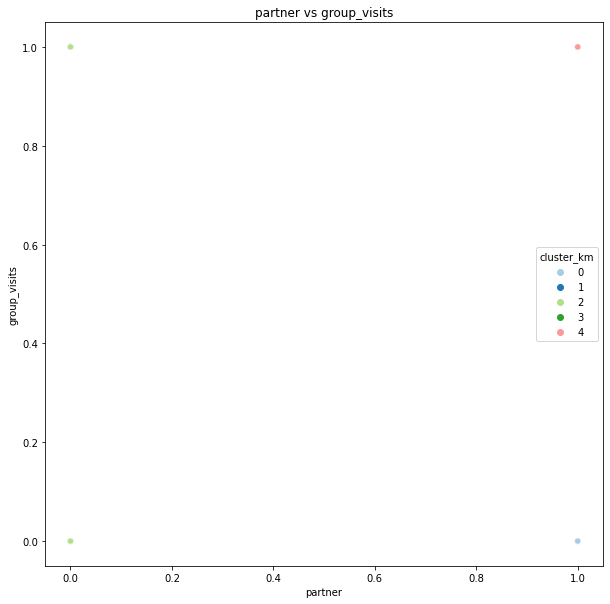

C:\Users\goncharova_aa\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


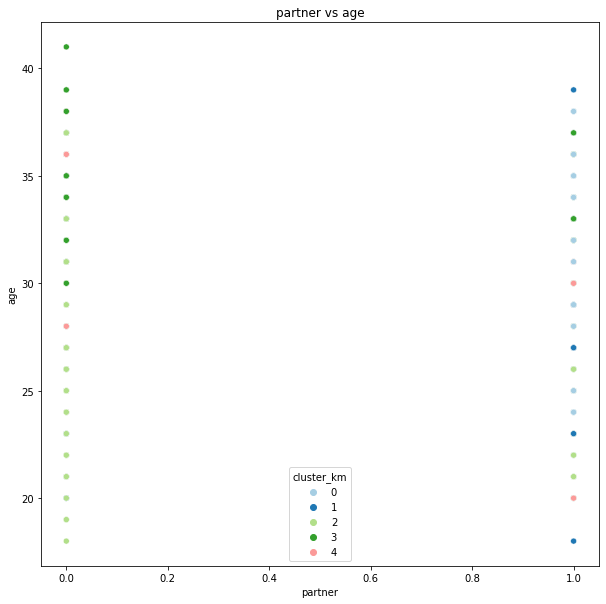

C:\Users\goncharova_aa\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


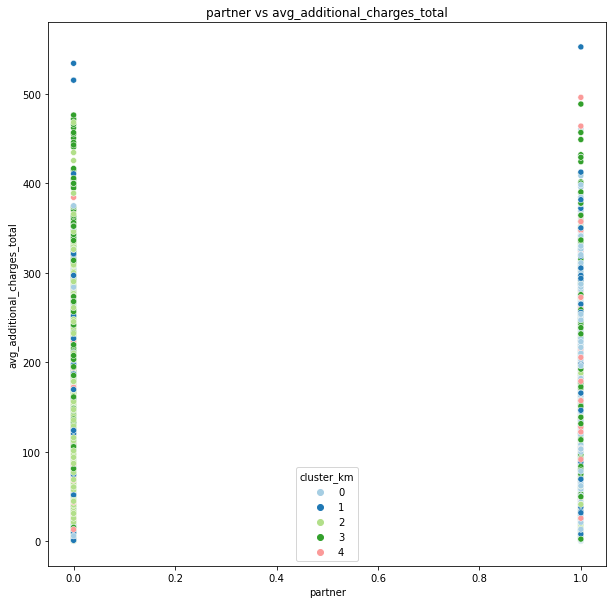

C:\Users\goncharova_aa\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


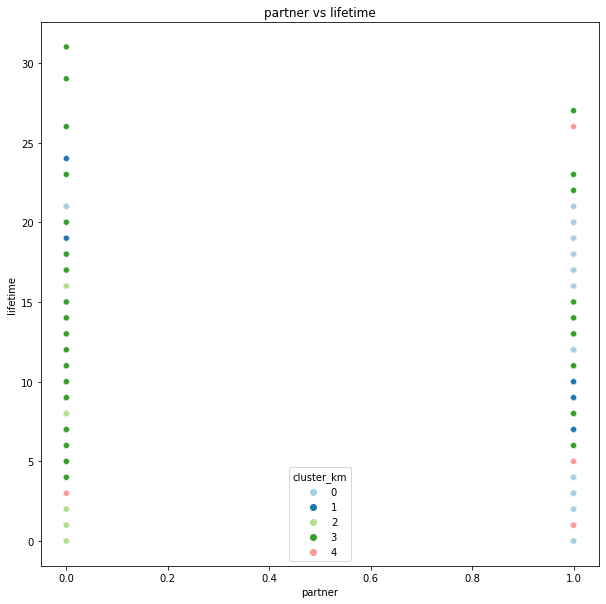

C:\Users\goncharova_aa\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


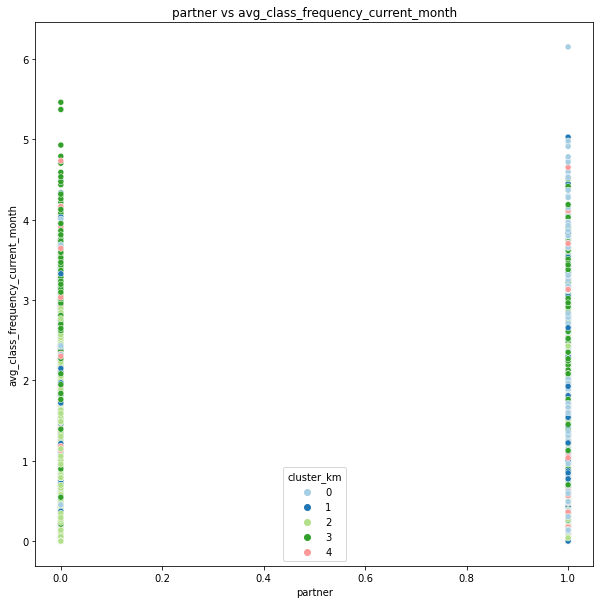

C:\Users\goncharova_aa\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


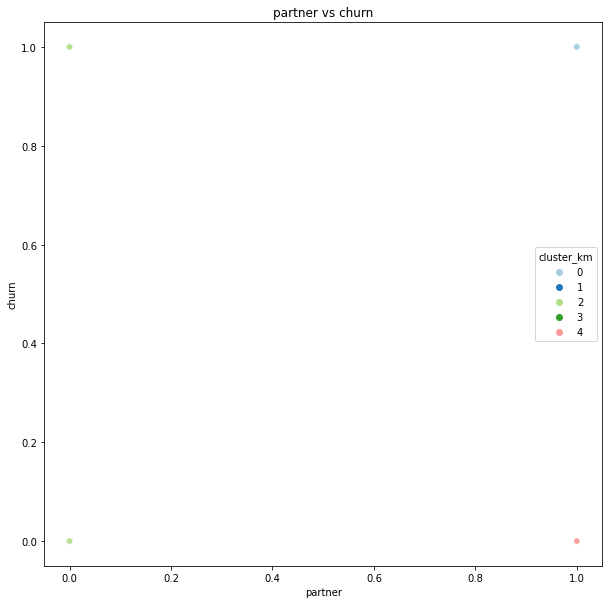

C:\Users\goncharova_aa\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


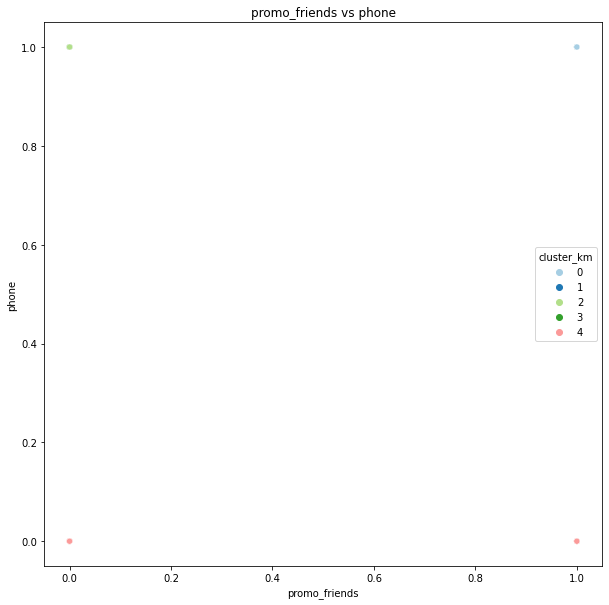

C:\Users\goncharova_aa\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


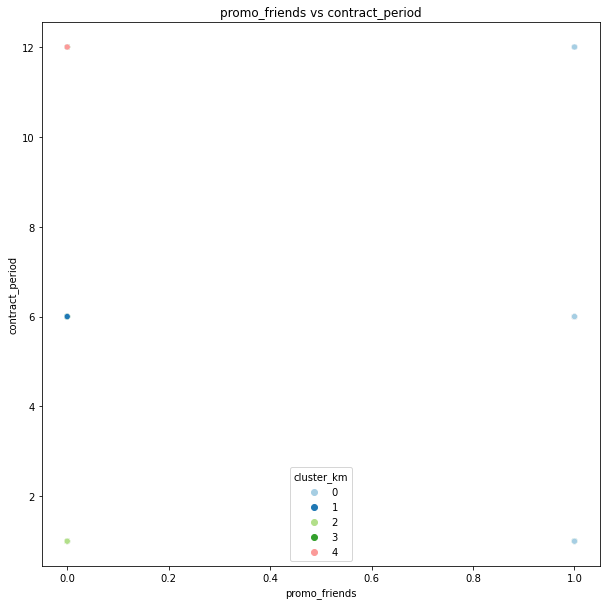

C:\Users\goncharova_aa\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


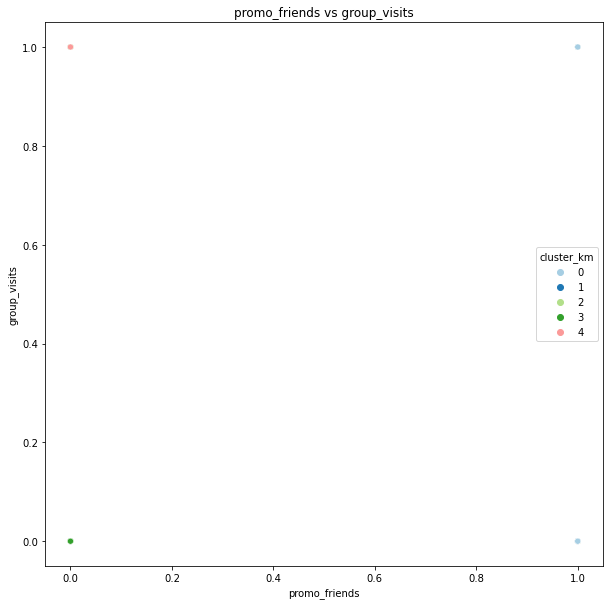

C:\Users\goncharova_aa\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


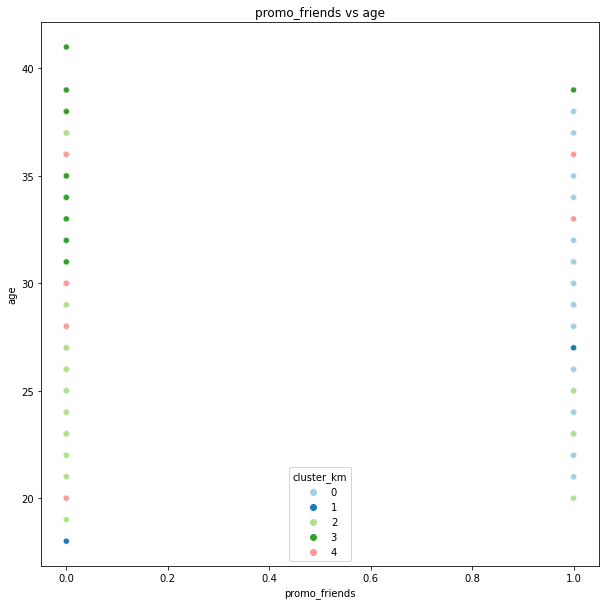

C:\Users\goncharova_aa\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


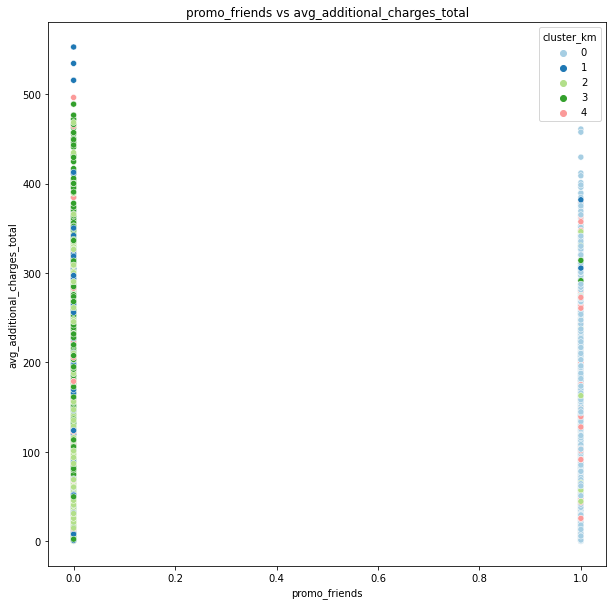

C:\Users\goncharova_aa\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


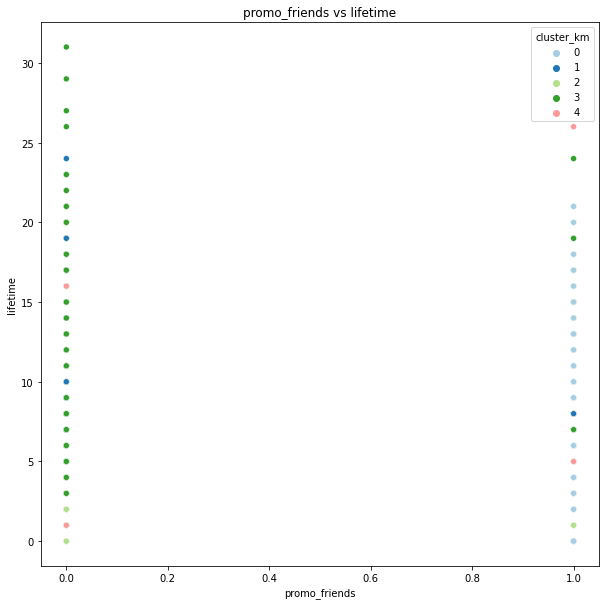

C:\Users\goncharova_aa\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


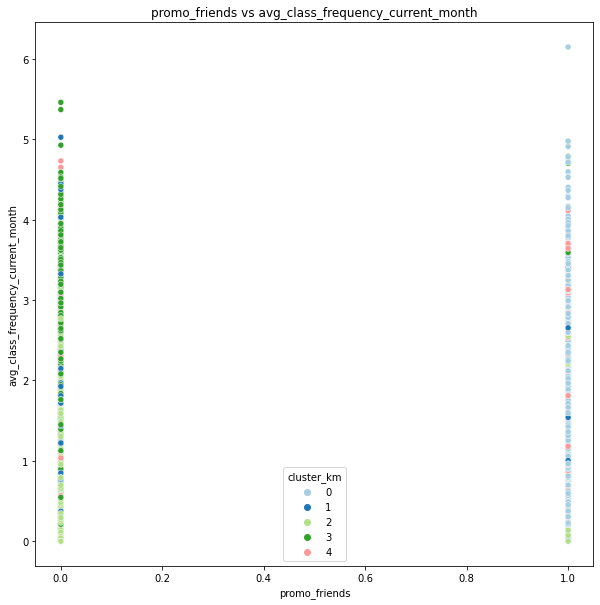

C:\Users\goncharova_aa\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


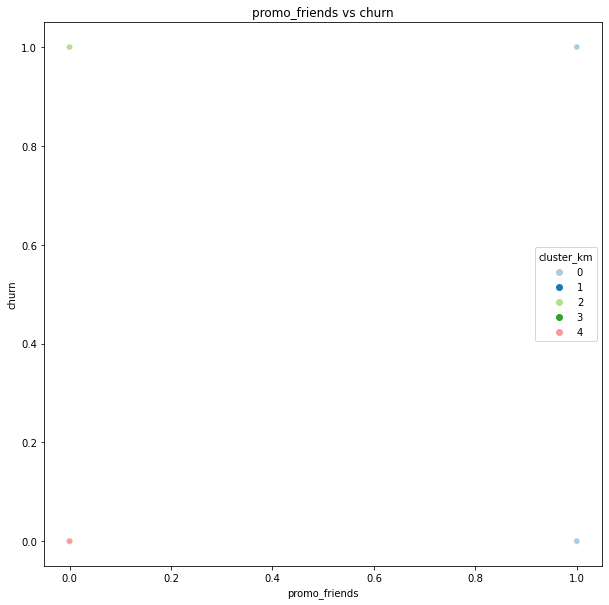

C:\Users\goncharova_aa\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


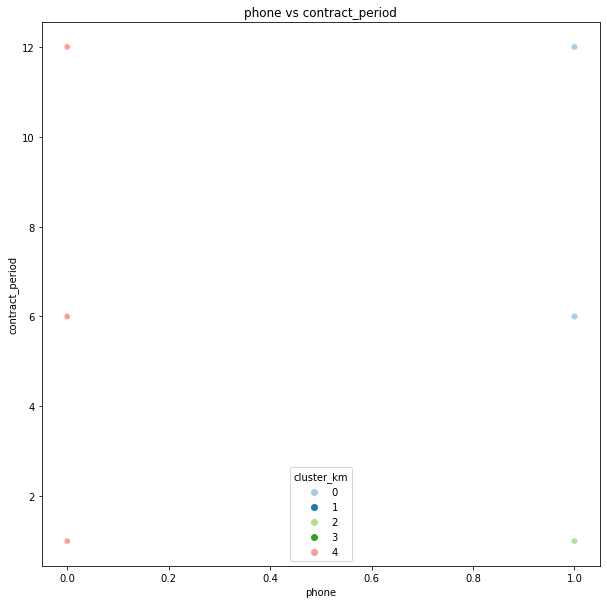

C:\Users\goncharova_aa\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


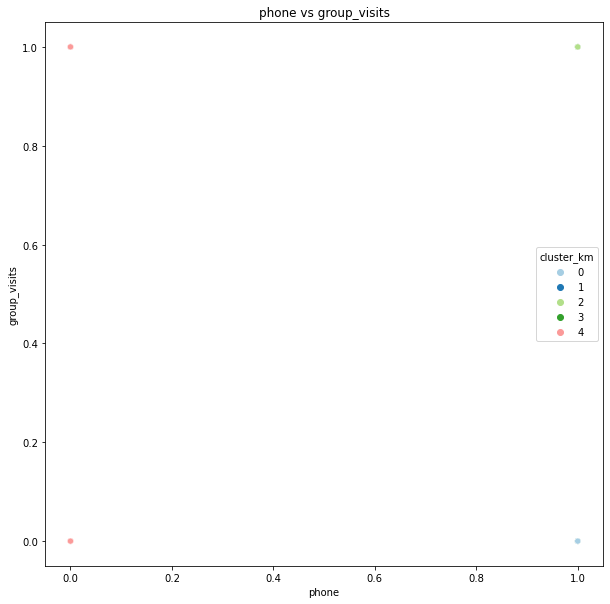

C:\Users\goncharova_aa\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


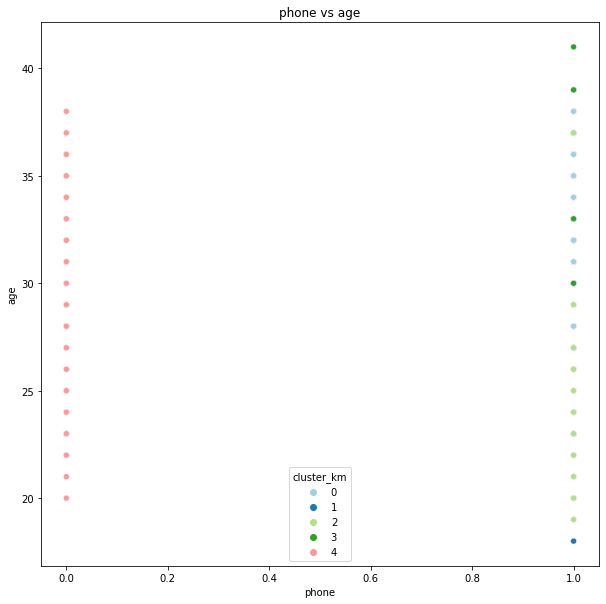

C:\Users\goncharova_aa\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


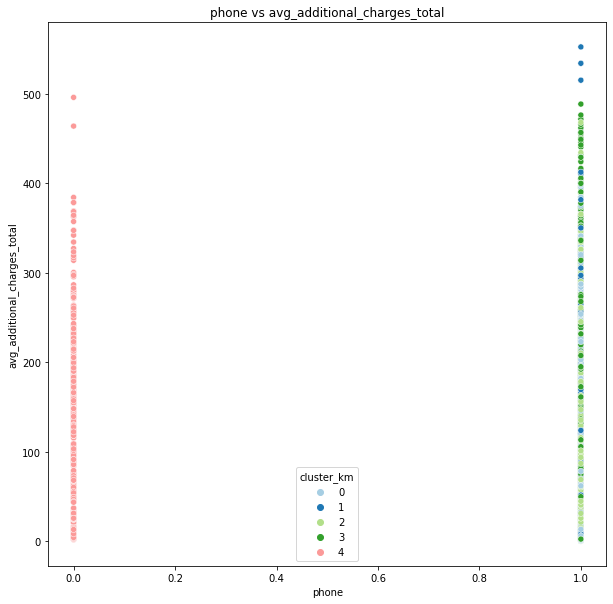

C:\Users\goncharova_aa\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


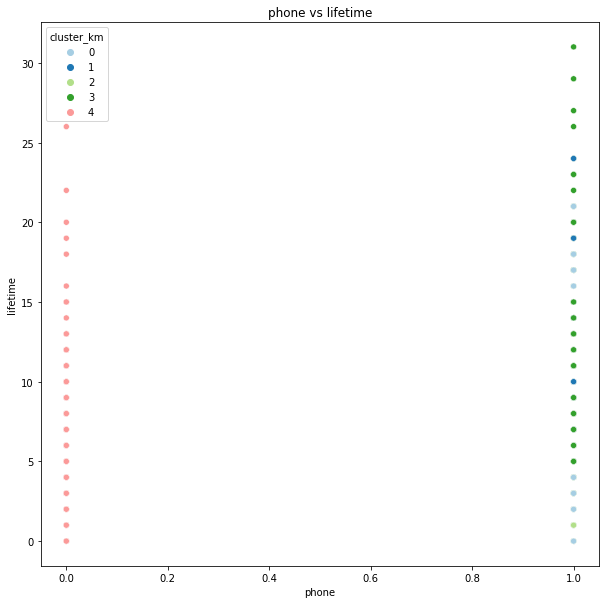

C:\Users\goncharova_aa\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


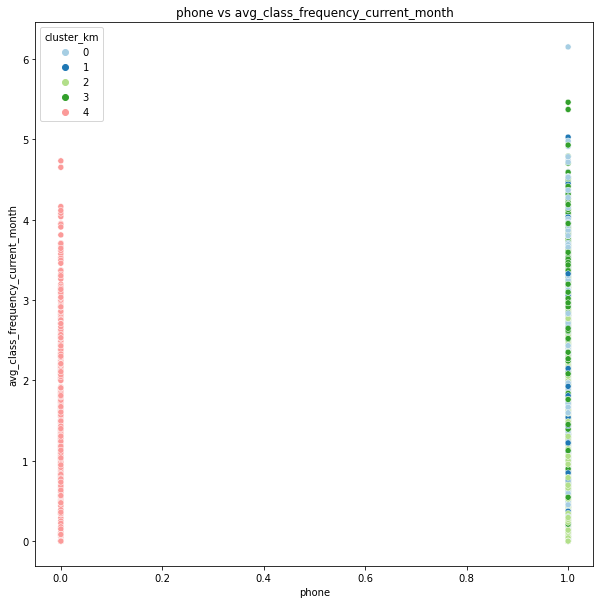

C:\Users\goncharova_aa\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


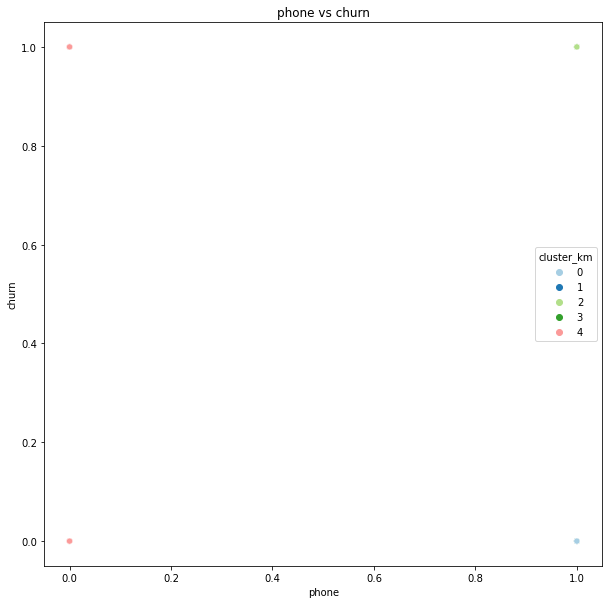

C:\Users\goncharova_aa\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


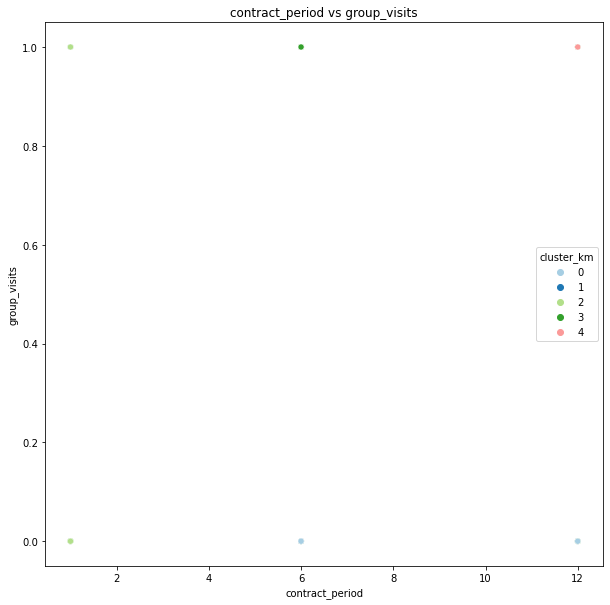

C:\Users\goncharova_aa\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


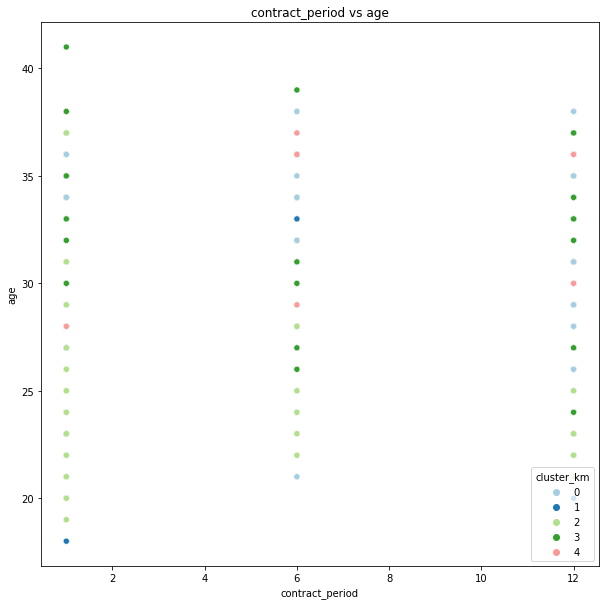

C:\Users\goncharova_aa\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


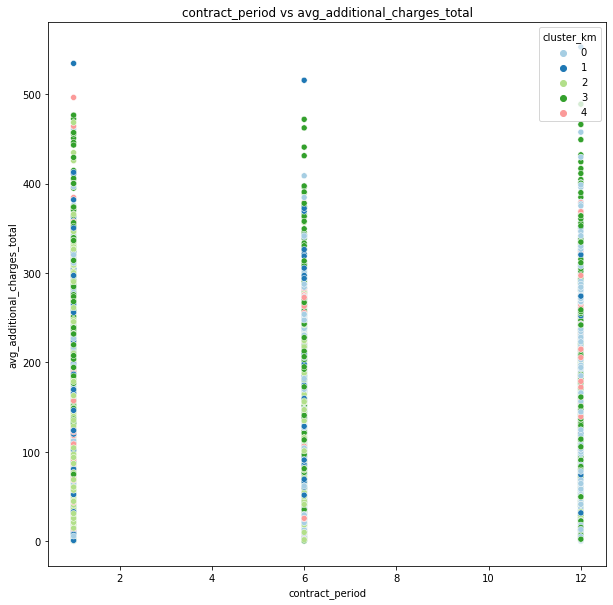

C:\Users\goncharova_aa\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


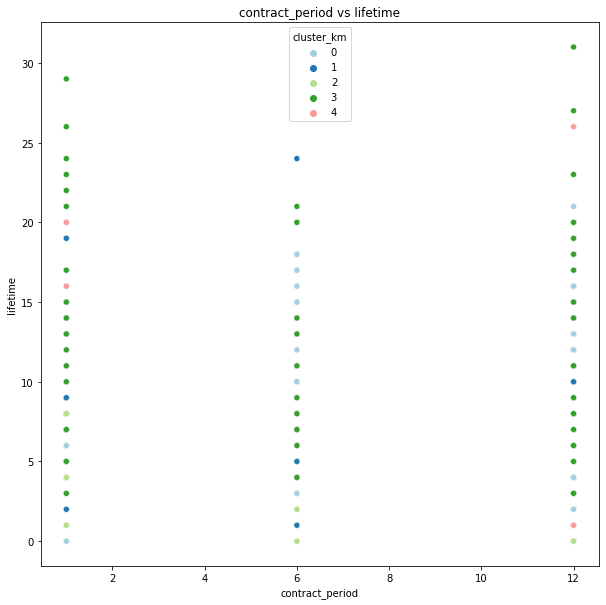

C:\Users\goncharova_aa\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


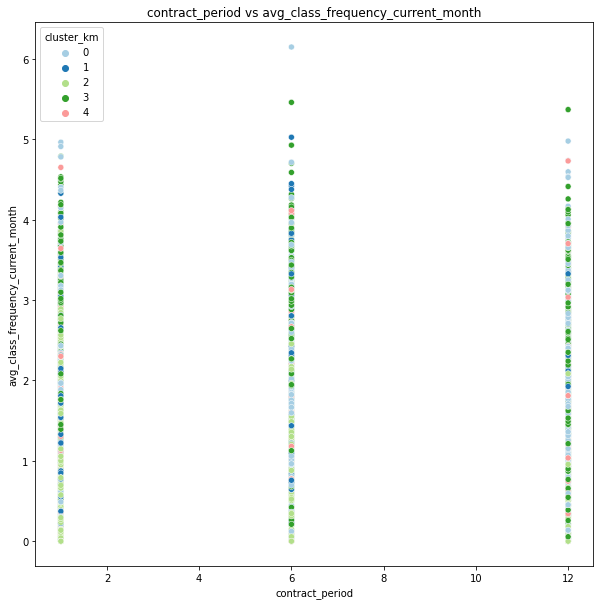

C:\Users\goncharova_aa\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


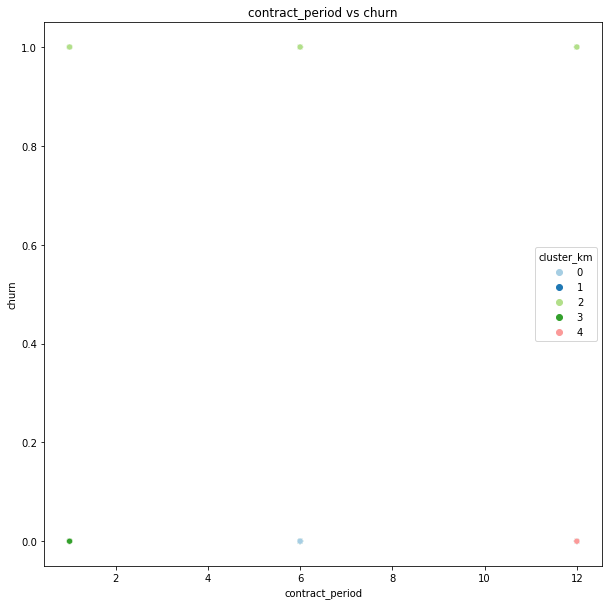

C:\Users\goncharova_aa\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


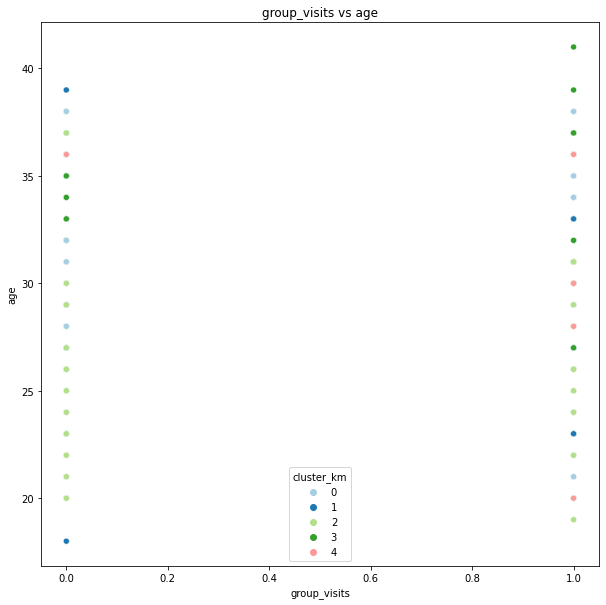

C:\Users\goncharova_aa\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


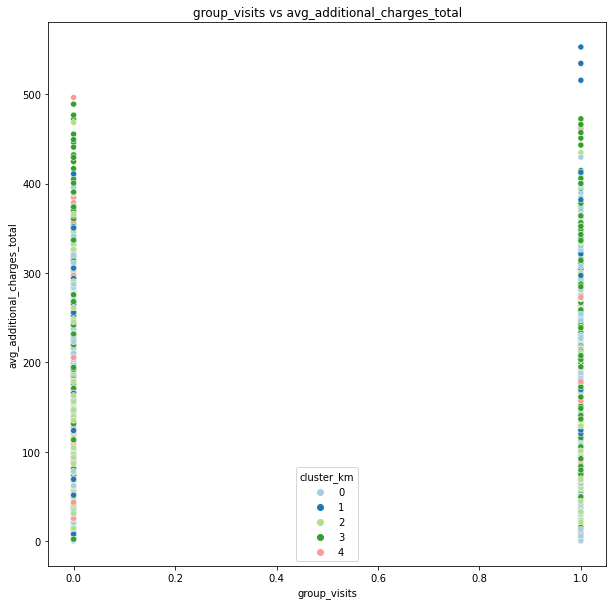

C:\Users\goncharova_aa\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


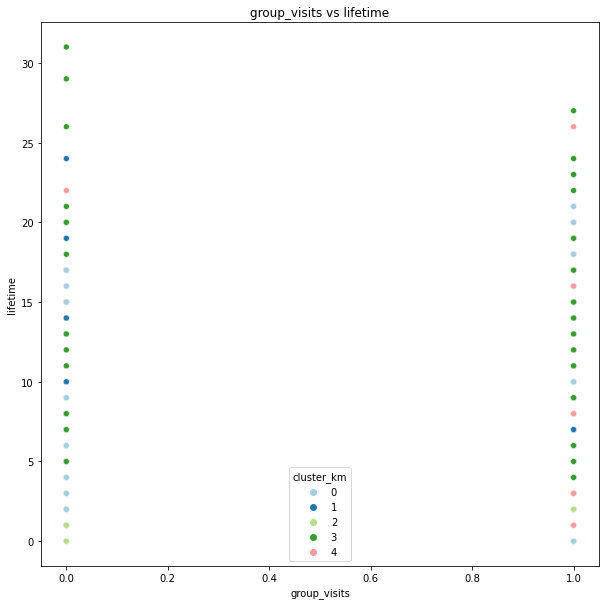

C:\Users\goncharova_aa\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


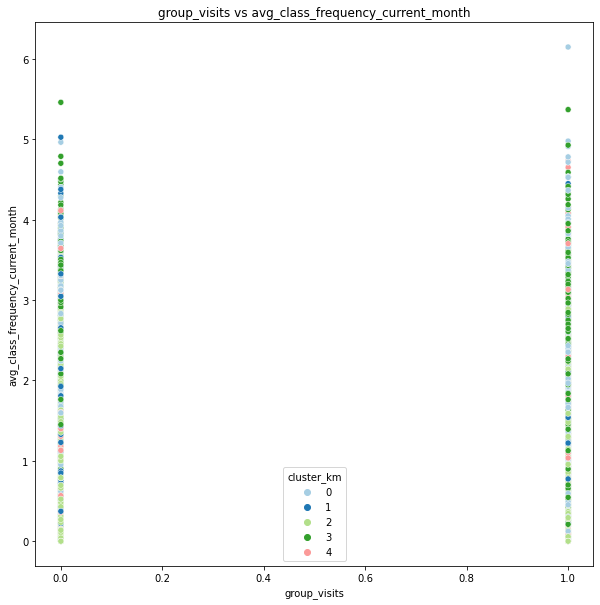

C:\Users\goncharova_aa\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


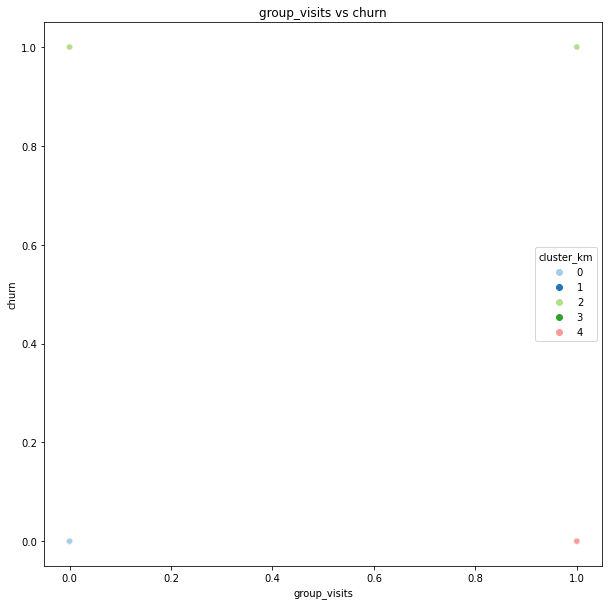

C:\Users\goncharova_aa\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


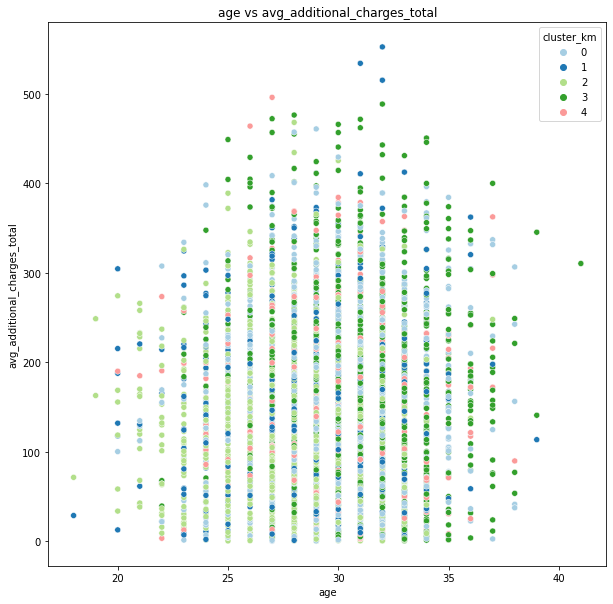

C:\Users\goncharova_aa\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


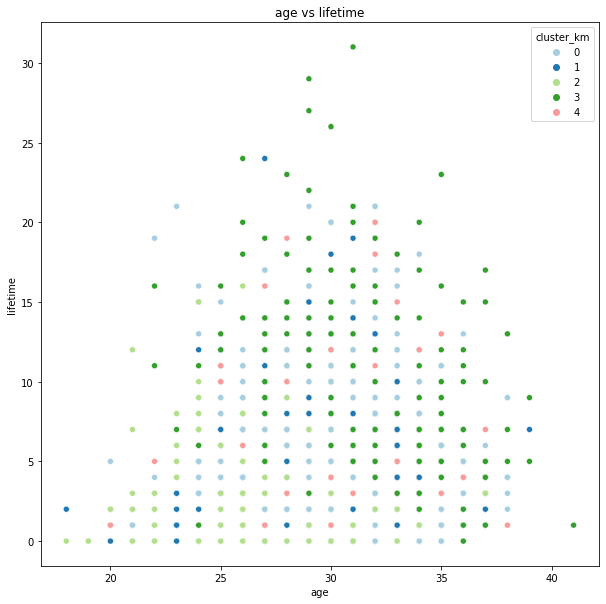

C:\Users\goncharova_aa\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


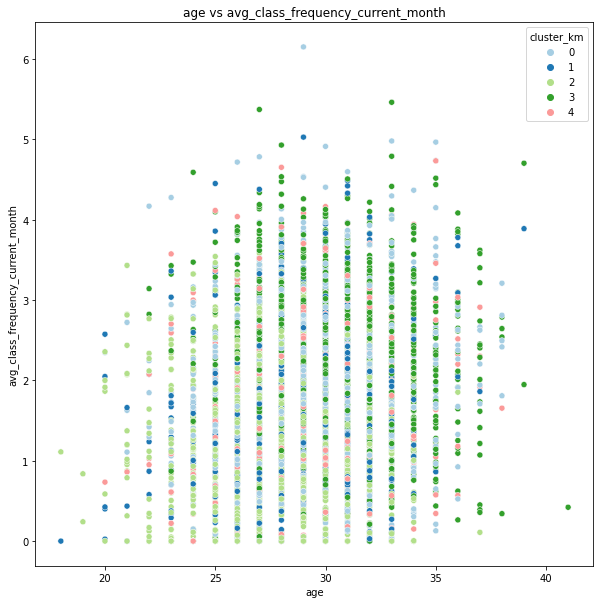

C:\Users\goncharova_aa\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


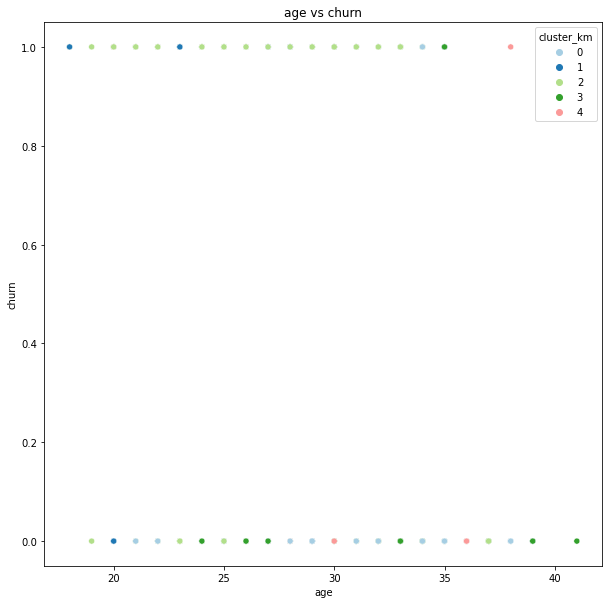

C:\Users\goncharova_aa\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


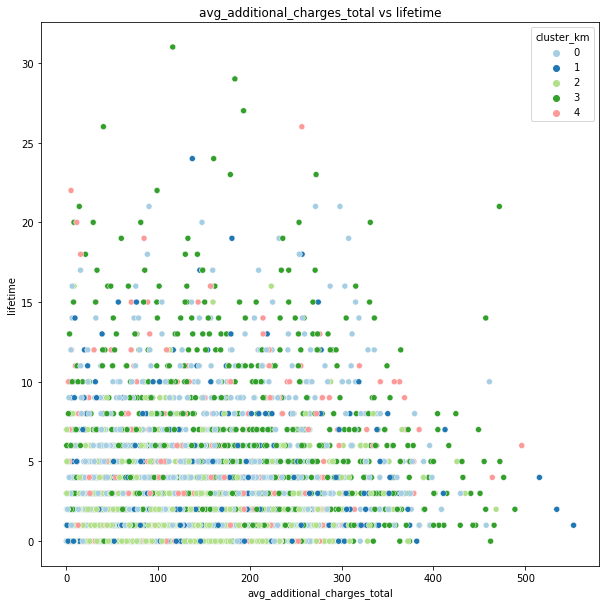

C:\Users\goncharova_aa\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


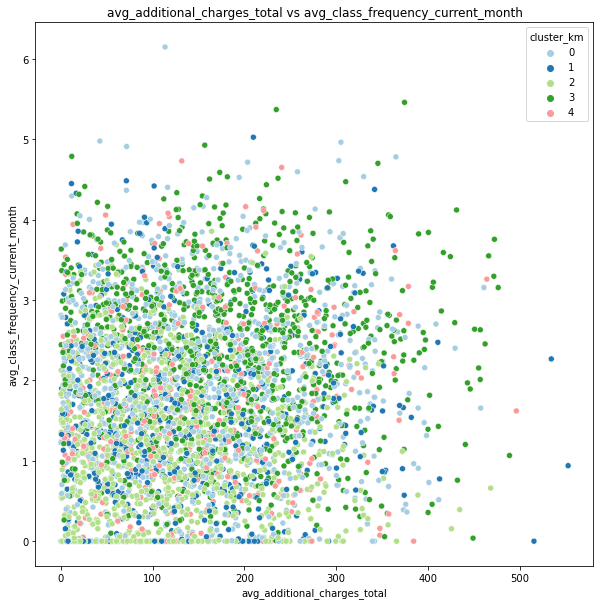

C:\Users\goncharova_aa\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


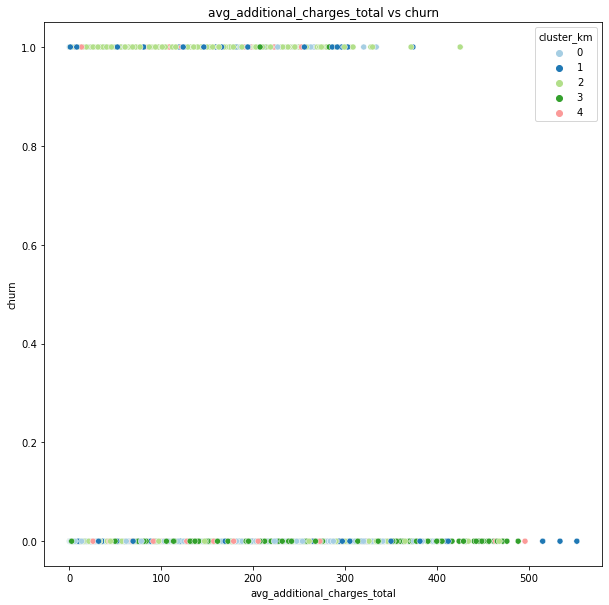

C:\Users\goncharova_aa\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


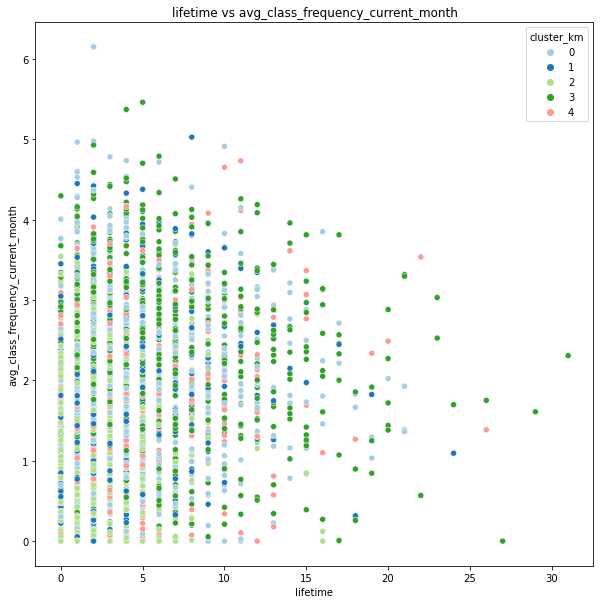

C:\Users\goncharova_aa\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


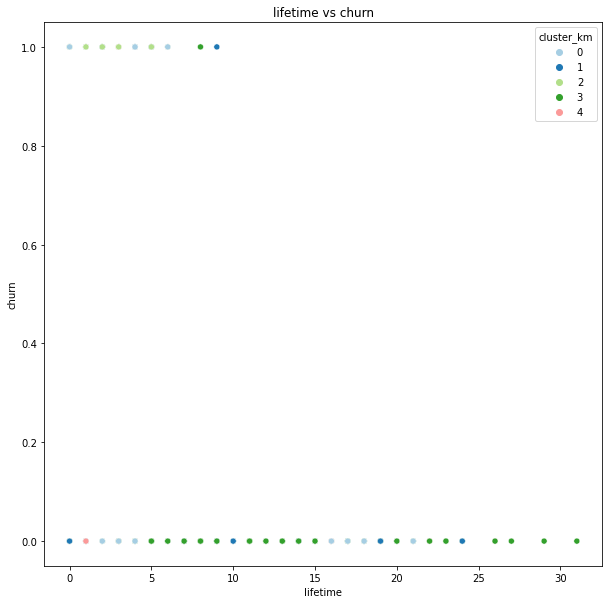

C:\Users\goncharova_aa\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


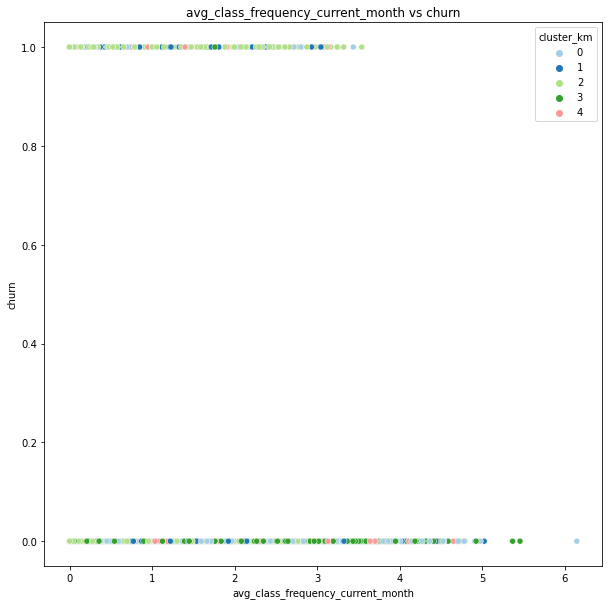

In [ ]:
def show_clusters_on_plot(df, x_name, y_name, cluster_name):
    plt.figure(figsize=(10,10))
    sns.scatterplot(
        df[x_name], df[y_name], hue=df[cluster_name], palette='Paired'
    )
    plt.title('{} vs {}'.format(x_name, y_name))
    plt.show()
data['cluster_km'] = labels
clusters = data.groupby(['cluster_km']).mean()
col_pairs = list(itertools.combinations(data.drop('cluster_km', axis=1).columns, 2))
for pair in col_pairs:
    show_clusters_on_plot(data, pair[0], pair[1], 'cluster_km')

In [ ]:
data.head()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,lifetime,avg_class_frequency_current_month,churn,cluster_km
0,1,1,1,1,0,6,1,29,14.227470,3,0.000000,0,4
1,0,1,0,0,1,12,1,31,113.202938,7,1.910244,0,3
2,0,1,1,0,1,1,0,28,129.448479,2,1.736502,0,2
3,0,1,1,1,1,12,1,33,62.669863,2,3.357215,0,0
4,1,1,1,1,1,1,0,26,198.362265,3,1.120078,0,0


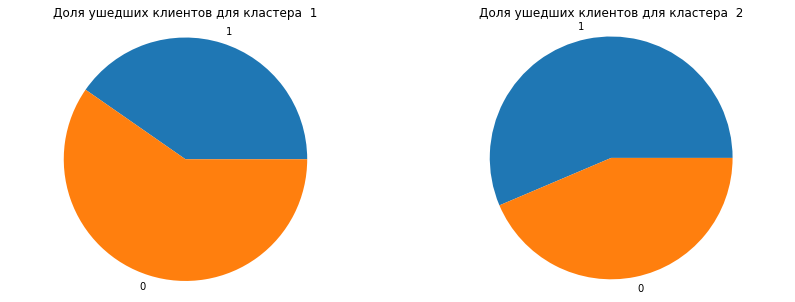

In [ ]:
cluster_1= data[data['cluster_km'] == 1]
d_grouped_chain = cluster_1.groupby(['churn']).count()
d_grouped_chain = d_grouped_chain.reset_index().sort_values(by = 'churn', ascending=False)
vals_chain = d_grouped_chain['cluster_km'].values
labels_chain = d_grouped_chain['churn']
fig = plt.figure(figsize=(14,5))
ax = fig.subplots(1, 2)
ax[0].pie(vals_chain, labels=labels_chain)
ax[0].axis("equal")
ax[0].set_title('Доля ушедших клиентов для кластера  1');
cluster_2= data[data['cluster_km'] == 2]
d_grouped_alone = cluster_2.groupby(['churn']).count()
d_grouped_alone = d_grouped_alone.reset_index().sort_values(by = 'churn', ascending=False)
labels_alone = d_grouped_alone['churn']
values_alone = d_grouped_alone['cluster_km'].values
#ax = plt.subplots()
ax[1].pie(values_alone, labels=labels_alone)
ax[1].axis("equal")
ax[1].set_title('Доля ушедших клиентов для кластера  2');

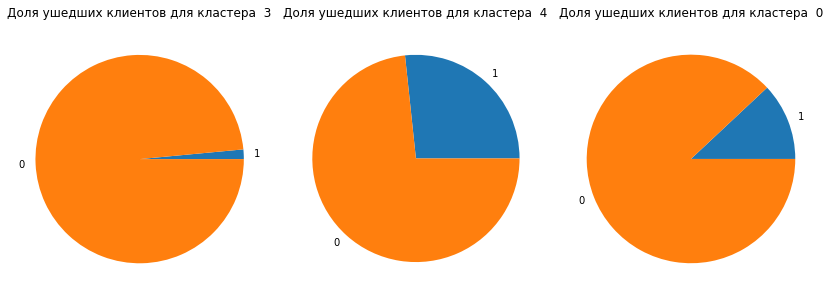

In [ ]:
cluster_3= data[data['cluster_km'] == 3]
d_grouped_chain = cluster_3.groupby(['churn']).count()
d_grouped_chain = d_grouped_chain.reset_index().sort_values(by = 'churn', ascending=False)
vals_chain = d_grouped_chain['cluster_km'].values
labels_chain = d_grouped_chain['churn']
fig = plt.figure(figsize=(14,5))
ax = fig.subplots(1, 3)
ax[0].pie(vals_chain, labels=labels_chain)
ax[0].axis("equal")
ax[0].set_title('Доля ушедших клиентов для кластера  3');
cluster_4= data[data['cluster_km'] == 4]
d_grouped_alone = cluster_4.groupby(['churn']).count()
d_grouped_alone = d_grouped_alone.reset_index().sort_values(by = 'churn', ascending=False)
labels_alone = d_grouped_alone['churn']
values_alone = d_grouped_alone['cluster_km'].values
#ax = plt.subplots()
ax[1].pie(values_alone, labels=labels_alone)
ax[1].axis("equal")
ax[1].set_title('Доля ушедших клиентов для кластера  4');
cluster_0= data[data['cluster_km'] == 0]
d_grouped_alone = cluster_0.groupby(['churn']).count()
d_grouped_alone = d_grouped_alone.reset_index().sort_values(by = 'churn', ascending=False)
labels_alone = d_grouped_alone['churn']
values_alone = d_grouped_alone['cluster_km'].values
ax[2].pie(values_alone, labels=labels_alone)
ax[2].axis("equal")
ax[2].set_title('Доля ушедших клиентов для кластера  0');

<ipython-input-93-8445648dd410>:33: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


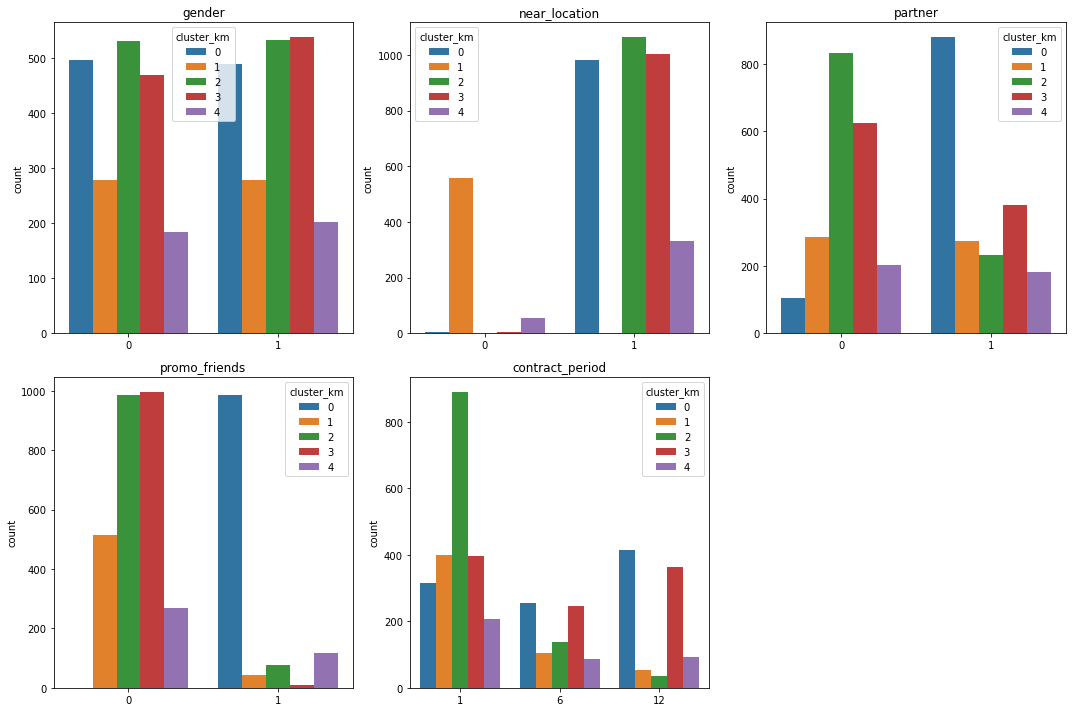

In [ ]:

# А теперь мы можем в каждую ячейку поместить свой график либо вручную либо в цикле. Лучше конечно в цикле:

# делаем новых холст в котором графики будут в 3 столбцах, а число строк - количество признаков деленное на 3

num_features = ['gender', 'near_location', 'partner', 'promo_friends', 'contract_period']
number_row = int(len(num_features)/3)
# добавим figsize=(15, 15) чтобы не было слишком мелкие графики
fig, ax = plt.subplots(nrows = number_row + 1, ncols=3, figsize=(15, 10))

# вытягиваем
ax = ax.flatten()

# задаем цикл

for i in range(len(num_features)):

    sns.countplot(x = data[num_features[i]], hue='cluster_km', data=data, ax = ax[i])

    ax[i].set_title(f'{num_features[i]}')
    ax[i].set_xlabel('')

# удалим последний, он пустой
fig.delaxes(ax[-1])

# чтобы все надписи влезли
fig.tight_layout()
fig.show()

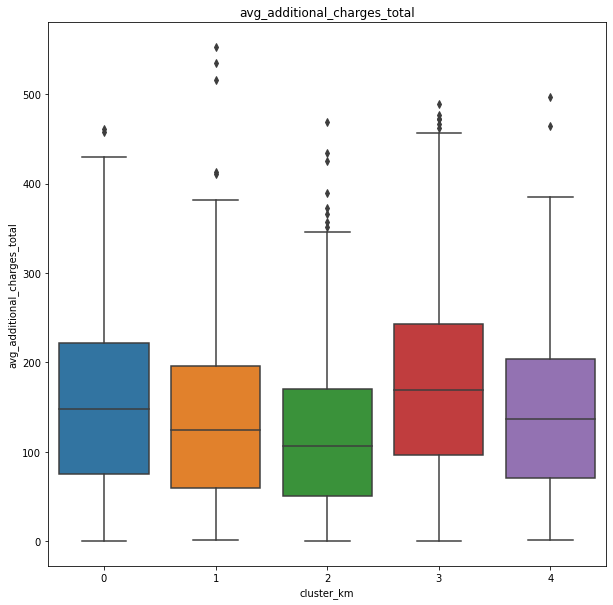

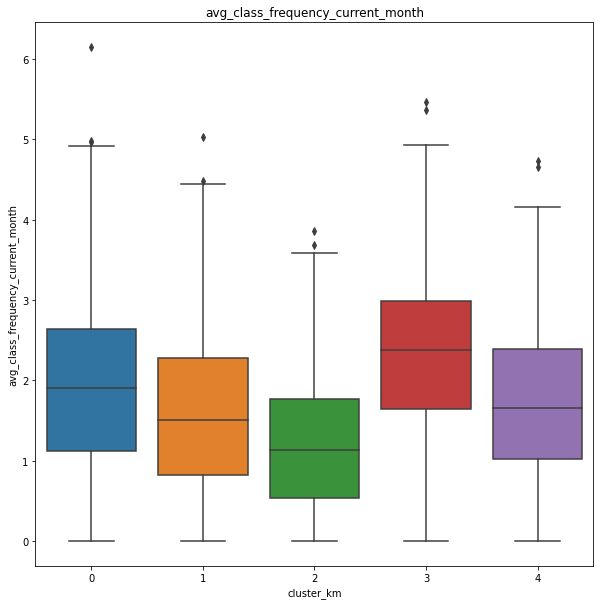

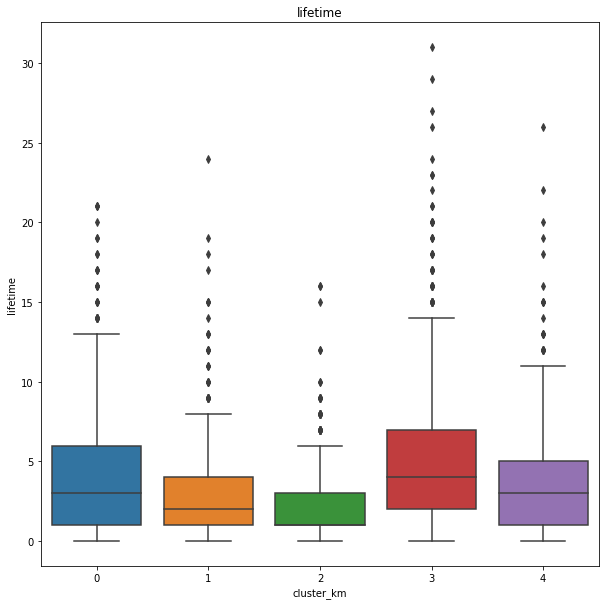

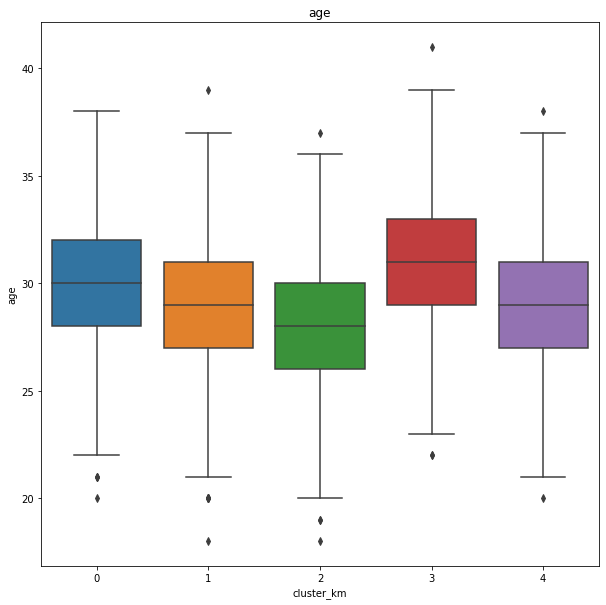

In [ ]:

for columns in ['avg_additional_charges_total', 'avg_class_frequency_current_month','lifetime', 'age']:
    plt.figure(figsize=(10, 10))
    sns.boxplot(x='cluster_km' ,y = data[columns],  data=data)
    plt.title(columns)
    plt.show()

In [ ]:
cluster_clients = data.pivot_table(index = 'cluster_km', aggfunc = 'mean' )
cluster_clients.head()

,age,avg_additional_charges_total,avg_class_frequency_current_month,churn,contract_period,gender,group_visits,lifetime,near_location,partner,phone,promo_friends
cluster_km,,,,,,,,,,,,
0,29.606091,153.424651,1.919520,0.119797,6.922843,0.496447,0.524873,4.283249,0.995939,0.892386,1,1.000000
1,28.679211,137.125763,1.597146,0.403226,2.994624,0.500000,0.232975,2.974910,0.000000,0.489247,1,0.078853
2,27.583647,119.339956,1.203319,0.563910,2.010338,0.500940,0.277256,1.922932,1.000000,0.217105,1,0.072368
3,30.699106,176.259567,2.324220,0.014896,6.208540,0.534260,0.538232,5.415094,0.996028,0.379345,1,0.009930
4,29.297927,144.208179,1.723967,0.266839,4.777202,0.523316,0.427461,3.940415,0.862694,0.471503,0,0.305699


2 и 3 кластер наиболее предрасположены к оттоку.
По 2 кластеру - эти клиенты в среднем ходят 3 месяца, меньше всех ходят на групповые занятия. Также молодые и ходят в зал 1,5 раза в неделю.
По 3 кластеру - Также молодые люди (28 лет), ходят не часто 1 раза в неделю, ходят чуть больше 2 месяцев, плохо посещают групповые занятия. Существенные отличия от 2 кластера в том, что они живут или работают не далеко от зала.

In [ ]:
cluster_features = data.groupby('cluster_km').mean().reset_index()
numeric_columns = cluster_features.drop(columns=['cluster_km']).columns
cluster_features.style.format({i: '{:.2f}' for i in numeric_columns}) \
        .highlight_max(color='yellowgreen', subset=numeric_columns) \
        .highlight_min(color='coral', subset=numeric_columns)

,cluster_km,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,lifetime,avg_class_frequency_current_month,churn
0,0,0.50,1.00,0.89,1.00,1.00,6.92,0.52,29.61,153.42,4.28,1.92,0.12
1,1,0.50,0.00,0.49,0.08,1.00,2.99,0.23,28.68,137.13,2.97,1.60,0.40
2,2,0.50,1.00,0.22,0.07,1.00,2.01,0.28,27.58,119.34,1.92,1.20,0.56
3,3,0.53,1.00,0.38,0.01,1.00,6.21,0.54,30.70,176.26,5.42,2.32,0.01
4,4,0.52,0.86,0.47,0.31,0.00,4.78,0.43,29.30,144.21,3.94,1.72,0.27


In [ ]:
cluster_features.T.style.background_gradient(cmap='coolwarm', axis=1).set_precision(2)

,0,1,2,3,4
cluster_km,0.00,1.00,2.00,3.00,4.00
gender,0.50,0.50,0.50,0.53,0.52
near_location,1.00,0.00,1.00,1.00,0.86
partner,0.89,0.49,0.22,0.38,0.47
promo_friends,1.00,0.08,0.07,0.01,0.31
phone,1.00,1.00,1.00,1.00,0.00
contract_period,6.92,2.99,2.01,6.21,4.78
group_visits,0.52,0.23,0.28,0.54,0.43
age,29.61,28.68,27.58,30.70,29.30
avg_additional_charges_total,153.42,137.13,119.34,176.26,144.21


# Выводы и рекомендации

Методы для предотвращения оттока клиентов.
1. Предлагать скидку за досрочное продление абонемента (так как наши клиенты уходят, когда абонементы подходят к концу, а новый они не покупают).  
2. Сделать большую разницу в цене месячного и полугодового абонемента. Если полугодовые абонементы будут выгоднее, тогда клиенты чаще будут их брать и реже уходить. (отток среди клиентов с абонементами от полу года меньше)
3. Прозвонить ушедших клиентов. Спросить почему перестали ходить. Возможны они не довольны обслуживанием или конкурент рядом предлагает условия лучше. Клиентам, которые идут на контакт можно давать бесплатное посещение. Больше вероятности, что они вернутся.   
4. Организовать соревнования. Например, по power lifting. Это поможет вовлечь клиентов заниматься активнее. Соревновательный дух. Люди будут ходить чаще в зал, чтобы подготовиться.
5. Чтобы увеличить вовлеченность в групповые занятия иногда стоит устраивать открытые уроки для новичков. Причем не обязательно только среди своих клиентов. Можно дать рекламу об открытом уроке, например Зумбы для всех желающих. Это простимулирует к групповым занятиям текущих клиентов и привлечет новых клиентов.   
6. Активно вести страницу в соцаальных сетях. Причем за упоминание клуба в соцсетях клиентам давать подарок, например, протеиновый батончик. На нашей странице клиентам будет интересно видеть три основных типа контента – это видео с красивыми движениями, процессы тренировок и результаты учеников. Последний является самым привлекательным для аудитории.
7. Более строгий контроль за персоналом. Имеется в виду качество обслуживания клиентов. В большинстве клубов фитнес-тренера говорят клиенту что делать, а потом сидят в телефоне, болтают с коллегами/другими клиентами, не обращая внимание на клиента. Если клиент берет услугу "Фитнес-тренер", то тренер должен уделять внимание, проявлять заботу о клиенте. Постоянно корректировать его движения, спрашивать не сложно ли заниматься и ничего ли не болит? Постоянно измерять результат.  



### Дополнительные выводы:  
   Мы проанализировали данные о клиентах фитнес-клуба. Наша задача была понять от чего зависит отток клиентов и спрогнозировать вероятность оттока у разных кластеров клиентов. Изначально мы ознакомились с данными. Провели исследовательский анализ данных. Проверили данные на выбросы и посмотрели на распределение. Оно показало, что оставшиеся клиенты чаще посещали фитнес-клуб, чаще ходили на групповые знаятия, брали более продолжительные абонементы, тратили на дополнительные услуги больше денег, часто посещали зал вместе с другом или коллегами. В целом создавалась благоприятная среда для посещения клуба как можно чаще. Далее мы решили спрогнозировать отток клиентов с помощью двух моделей ML. Это линейная регрессия и метод случайного леса. Метод линейной регрессии показал себя лучше. В качестве критерия оценки мы использовали ACC. Мы также провели кластеризацию клиентов. Выявили наиболее проблемные кластера. В конце мы предложили рекомендации для уменьшения оттока клиентов.